In [150]:
import pandas as pd
import numpy as np
import datetime
import random
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats, integrate
pd.options.display.max_columns = 100

Create The Dataset

In [3]:
# Number of entries
PolicyCount = 15000
# 9-year period
YearEndCap = 2017
YearStartCap = 2007
# Dates
DateEndCap = datetime.date(YearEndCap, 12, 31)    # year, month, day
DateStartCap = datetime.date(YearStartCap, 12, 31)  # year, month, day

No admin costs, claims paid in bulk on transaction date rather than multiple dates for those with multiple claims, ignoring earned gross premium calculations etc

In [4]:
# Establish initial data-frame
columns_1 = ['Insured_ID', 'Insured_Date', 'Claims_Number', 'Claims_Amount', 'Transaction_Date',
           'Insured_Year', 'Insured_Quarter',
           'Transaction_Year', 'Transaction_Quarter']
ClaimsData = pd.DataFrame(columns=columns_1)

In [9]:
ClaimsData['Insured_ID'] = list(range(1, PolicyCount+1))

In [10]:
import random
for row in range(0, PolicyCount):
    n_days = (DateEndCap-DateStartCap).days
    random_days = random.randint(0, n_days-1)
    Random_Insured_Date = DateStartCap + datetime.timedelta(days=1) + datetime.timedelta(days=random_days)
    ClaimsData.loc[row, 'Insured_Date'] = Random_Insured_Date

We are assigning poisson distribution to the rate at which the claims are Incurred.

In [12]:
Lambda = 10
Size = 1
for row in range(0, PolicyCount):
    ClaimCount = np.random.poisson(1, 1)
    ClaimsData.loc[row, 'Claims_Number'] = ClaimCount

ClaimsData['Claims_Number'] = pd.DataFrame(ClaimsData['Claims_Number'].values.tolist())

In [14]:
def trunc_amt(mu, sigma, bottom, top):
    a = random.lognormal(mu,sigma)
    while (bottom <= a <= top) == False:
        a = random.lognormal(mu,sigma)
    return a

Now we just assign random claim amounts to the data. Also, Making sure that the Claim Amount remains 0 for tthe year where the claim number is 0.

In [ ]:
MeanClaimAmt = 10
StdDevClaimAmt = 4
for row in range(0, PolicyCount):
    if ClaimsData.loc[row, 'Claims_Number'] == 0:
        ClaimsData.loc[row, 'Claims_Amount'] = 0
    else:
        ClaimNumber = ClaimsData.loc[row, 'Claims_Number']
        num = np.random.lognormal(MeanClaimAmt, StdDevClaimAmt, ClaimNumber).sum()
        ClaimsData.loc[row, 'Claims_Amount'] = num


ClaimsData['Claims_Amount'] = pd.DataFrame(ClaimsData['Claims_Amount'].values.tolist())


In [19]:
for row in range(0, PolicyCount):
    DateStart = ClaimsData.loc[row, 'Insured_Date']
    if ClaimsData.loc[row, 'Claims_Number'] == 0:
        ClaimsData.loc[row, 'Transaction_Date'] = DateStart
    elif (DateEndCap-DateStart).days <=0:
        ClaimsData.loc[row, 'Transaction_Date'] = DateStart
    else:
        n_days = (DateEndCap-DateStart).days
        random_days = random.randint(1, n_days)
        Random_Transaction_Date = DateStart + datetime.timedelta(days=random_days)
        ClaimsData.loc[row, 'Transaction_Date'] = Random_Transaction_Date

In [20]:
ClaimsData['Insured_Year'] = ClaimsData['Insured_Date'].apply(lambda x: x.year)
ClaimsData['Transaction_Year'] = ClaimsData['Transaction_Date'].apply(lambda x: x.year)
# Insured Month
ClaimsData['Insured_Quarter'] = ClaimsData['Insured_Date'].apply(lambda x: x.month)
ClaimsData['Transaction_Quarter'] = ClaimsData['Transaction_Date'].apply(lambda x: x.month)
print(ClaimsData[['Insured_Date', 'Insured_Year', 'Transaction_Date', 'Transaction_Year']])

      Insured_Date  Insured_Year Transaction_Date  Transaction_Year
0       2013-06-16          2013       2014-07-16              2014
1       2017-03-17          2017       2017-03-17              2017
2       2017-04-22          2017       2017-11-02              2017
3       2012-08-20          2012       2014-03-30              2014
4       2008-03-23          2008       2016-06-22              2016
...            ...           ...              ...               ...
14995   2009-02-25          2009       2016-05-08              2016
14996   2013-04-19          2013       2016-03-23              2016
14997   2008-04-13          2008       2008-04-13              2008
14998   2009-07-06          2009       2012-09-04              2012
14999   2011-06-16          2011       2011-09-25              2011

[15000 rows x 4 columns]


In [21]:
ClaimsData['Year_Only_Lag'] = ClaimsData['Transaction_Year'] - ClaimsData['Insured_Year']

In [22]:
ClaimsData.head()

,Insured_ID,Insured_Date,Claims_Number,Claims_Amount,Transaction_Date,Insured_Year,Insured_Quarter,Transaction_Year,Transaction_Quarter,Year_Only_Lag
0,1,2013-06-16,3,1.336623e+05,2014-07-16,2013,6,2014,7,1
1,2,2017-03-17,0,0.000000e+00,2017-03-17,2017,3,2017,3,0
2,3,2017-04-22,2,2.717952e+02,2017-11-02,2017,4,2017,11,0
3,4,2012-08-20,2,6.218203e+07,2014-03-30,2012,8,2014,3,2
4,5,2008-03-23,1,2.272905e+04,2016-06-22,2008,3,2016,6,8


Now we create a column "cumsum" which includes the cumulative claims amount value at any particular time of the priod considered.
This values are not Subject to inflation yet.

In [23]:
py_data = ClaimsData['Claims_Amount'].groupby([ClaimsData['Insured_Year'], ClaimsData['Year_Only_Lag']]).sum().reset_index()
# Convert into data-frame
py_data = pd.DataFrame(py_data)
# Cumulative Claims Amount
py_data["cumsum"] = py_data["Claims_Amount"].groupby(py_data["Insured_Year"]).cumsum()

In [46]:
py_data.tail()

,Insured_Year,Year_Only_Lag,Claims_Amount,cumsum,Inflated_Claims_Amount
50,2015,1,5.605955e+10,5.714481e+10,5.552565e+10
51,2015,2,1.067904e+10,6.782385e+10,1.067904e+10
52,2016,0,4.623433e+10,4.623433e+10,4.579400e+10
53,2016,1,2.203860e+10,6.827293e+10,2.203860e+10
54,2017,0,3.911162e+10,3.911162e+10,3.911162e+10


We create a different dataframe to store the values of inflation rates with respect to their Years.

In [60]:
columns_2 = ['Year', 'CumPastInflation']
Inflation_df = pd.DataFrame(columns=columns_2)
Inflation_df['Year'] = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Inflation_df['CumPastInflation'] = [1.32, 1.27, 1.28, 1.22, 1.16, 1.12, 1.09, 1.07, 1.05, 1.04, 1.00]
display(Inflation_df)

,Year,CumPastInflation
0,2008,1.32
1,2009,1.27
2,2010,1.28
3,2011,1.22
4,2012,1.16
5,2013,1.12
6,2014,1.09
7,2015,1.07
8,2016,1.05
9,2017,1.04


We need to calculate the Cumulative claims amount with respect to inflation, so we create a different column named "Inflated_Claims_Amount"

In [105]:
py_data['Inflated_Claims_Amount'] = py_data['Claims_Amount']

for row in range(0, len(py_data['Insured_Year'])):
    InsuredYear = py_data.loc[row,'Insured_Year']
    LagYear = py_data.loc[row,'Year_Only_Lag']
    TransactionYear = InsuredYear + LagYear
    for year in range(0, len(Inflation_df['Year'])):
        CurrentYearInflation = Inflation_df.loc[year,'Year']
        if  CurrentYearInflation == InsuredYear:
            CurrentYearPerc = Inflation_df.loc[Inflation_df['Year'] == TransactionYear,'CumPastInflation']
            ToYearPerc = Inflation_df.loc[Inflation_df['Year']==YearEndCap,'CumPastInflation'].iloc[0]
            Uplift = ToYearPerc / CurrentYearPerc        
            py_data.loc[row,'Inflated_Claims_Amount'] = py_data.loc[row,'Inflated_Claims_Amount']*(Uplift.values[0])
        else:
            pass

In [106]:
py_data.tail()

,Insured_Year,Year_Only_Lag,Claims_Amount,cumsum,Inflated_Claims_Amount
50,2015,1,5.605955e+10,5.714481e+10,5.552565e+10
51,2015,2,1.067904e+10,6.782385e+10,1.067904e+10
52,2016,0,4.623433e+10,4.623433e+10,4.579400e+10
53,2016,1,2.203860e+10,6.827293e+10,2.203860e+10
54,2017,0,3.911162e+10,3.911162e+10,3.911162e+10


In [116]:
py_data['Inflated_cumsum'] = py_data['Inflated_Claims_Amount'].groupby(py_data['Insured_Year']).cumsum()
py_data.head()

,Insured_Year,Year_Only_Lag,Claims_Amount,cumsum,Inflated_Claims_Amount,Inflated_cumsum
0,2008,0,5.414635e+08,5.414635e+08,4.266076e+08,4.266076e+08
1,2008,1,1.885603e+09,2.427066e+09,1.544116e+09,1.970723e+09
2,2008,2,2.181758e+09,4.608824e+09,1.772678e+09,3.743402e+09
3,2008,3,4.352050e+09,8.960874e+09,3.709944e+09,7.453345e+09
4,2008,4,2.976080e+09,1.193695e+10,2.668210e+09,1.012156e+10


calculating Loss dicount factor (LDF) with repect to inflation

In [140]:
py_data['Inflated_LossDF'] = 1

for row in range(0, len(py_data['Insured_Year'])):
    InsuredYear = py_data.loc[row, 'Insured_Year']
    LagYr = py_data.loc[row, 'Year_Only_Lag']
    CurrentYear = py_data.loc[row, 'Insured_Year'] + py_data.loc[row, 'Year_Only_Lag']
    CurrCumAmt = py_data.loc[row, 'Inflated_cumsum']

    if CurrentYear > YearEndCap or len(py_data.loc[(py_data['Insured_Year'] == InsuredYear) & (
            py_data['Year_Only_Lag'] == (LagYr + 1)), 'Inflated_cumsum']) == 0:
        NextCumAmt = 0
    else:
        NextCumAmt = py_data.loc[(py_data['Insured_Year'] == InsuredYear) & (
                    py_data['Year_Only_Lag'] == (LagYr + 1)), 'Inflated_cumsum'].values[0]

    LDF = NextCumAmt / CurrCumAmt
    py_data.loc[row, 'Inflated_LossDF'] = LDF

py_data.head()

/var/folders/4y/r8t245md0712rsd6jcyf8qn40000gn/T/ipykernel_33754/1179464869.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.61952276251651' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  py_data.loc[row, 'Inflated_LossDF'] = LDF


,Insured_Year,Year_Only_Lag,Claims_Amount,cumsum,Inflated_Claims_Amount,Inflated_cumsum,Inflated_LossDF,Inflated_LossDF1
0,2008,0,5.414635e+08,5.414635e+08,4.266076e+08,4.266076e+08,4.619523,4.619523
1,2008,1,1.885603e+09,2.427066e+09,1.544116e+09,1.970723e+09,1.899506,1.899506
2,2008,2,2.181758e+09,4.608824e+09,1.772678e+09,3.743402e+09,1.991062,1.991062
3,2008,3,4.352050e+09,8.960874e+09,3.709944e+09,7.453345e+09,1.357988,1.357988
4,2008,4,2.976080e+09,1.193695e+10,2.668210e+09,1.012156e+10,1.051693,1.051693


In [145]:
# Non Inflated
py_data['LossDF'] = 1

for row in range(0, len(py_data['Insured_Year'])):
    InsuredYear = py_data.loc[row, 'Insured_Year']
    LagYr = py_data.loc[row, 'Year_Only_Lag']
    CurrentYear = py_data.loc[row, 'Insured_Year'] + py_data.loc[row, 'Year_Only_Lag']
    CurrCumAmt = py_data.loc[row, 'cumsum']

    if CurrentYear > YearEndCap or len(py_data.loc[(py_data['Insured_Year'] == InsuredYear) & (
            py_data['Year_Only_Lag'] == (LagYr + 1)), 'cumsum']) == 0:
        NextCumAmt = 0
    else:
        # .values[0] code to output only values and not entire row
        NextCumAmt = py_data.loc[
            (py_data['Insured_Year'] == InsuredYear) & (py_data['Year_Only_Lag'] == (LagYr + 1)), 'cumsum'].values[0]

    LDF = NextCumAmt / CurrCumAmt
    py_data.loc[row, 'LossDF'] = LDF

py_data.head()

/var/folders/4y/r8t245md0712rsd6jcyf8qn40000gn/T/ipykernel_33754/2941050632.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.482419627572703' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  py_data.loc[row, 'LossDF'] = LDF


,Insured_Year,Year_Only_Lag,Claims_Amount,cumsum,Inflated_Claims_Amount,Inflated_cumsum,Inflated_LossDF,LossDF
0,2008,0,5.414635e+08,5.414635e+08,4.266076e+08,4.266076e+08,4.619523,4.482420
1,2008,1,1.885603e+09,2.427066e+09,1.544116e+09,1.970723e+09,1.899506,1.898928
2,2008,2,2.181758e+09,4.608824e+09,1.772678e+09,3.743402e+09,1.991062,1.944286
3,2008,3,4.352050e+09,8.960874e+09,3.709944e+09,7.453345e+09,1.357988,1.332119
4,2008,4,2.976080e+09,1.193695e+10,2.668210e+09,1.012156e+10,1.051693,1.047203


In [ ]:
def SinglePlotPartialClaims(DataFrameName, InsuredYearColumn, LagYearColumn, ValueColumn):
    """Create New df"""
    Filtered_NewColumnNames = ["Insured_Year","Year_Only_Lag","ClaimAmt"]
    Filtered_df = pd.DataFrame(DataFrameName[[InsuredYearColumn, LagYearColumn, ValueColumn]])
    Filtered_df.columns = Filtered_NewColumnNames
    """Unique Insured Years List"""
    InsuredYr_List = list(DataFrameName[InsuredYearColumn].unique())
    """Unique Lag Years List"""
    LagYr_List = list(DataFrameName[LagYearColumn].unique())
    """Color List"""
    ALL_Colors = ['r','b','g','y','k', 'c', 'm', 'saddlebrown', 'pink', 'lawngreen']         
    Color_List = ALL_Colors[:len(InsuredYr_List)]
    """LineStyle List"""
    ALL_LineStyle = ['-', '--', '-.', ':','-','-','-','-','-','-','-','-','-']
    LineStyle_List = ALL_LineStyle[:len(InsuredYr_List)]
    """MarkerStyle List"""# First 4x empty 
    ALL_Markers = ['','','','','^','.','o','*', '+', '1', '2', '3', '4']
    Marker_List = ALL_Markers[:len(InsuredYr_List)]
    """Loop Plot"""
    for row_A in range(0,len(InsuredYr_List)):
        plt.figure(2, figsize=(10,5))
        Year_i = InsuredYr_List[row_A]
        SubFiltered_df = Filtered_df.loc[Filtered_df['Insured_Year'].isin([Year_i])]
        plt.plot(SubFiltered_df['Year_Only_Lag'], SubFiltered_df['ClaimAmt'], 
                 label=str(Year_i), linestyle='-', color=Color_List[row_A])
    """Plot Attributes"""    
    plt.xlabel('Developement Year')
    plt.ylabel('Claims Value')
    plt.title('Single Plot Partial Claims Data')
    plt.legend()
    plt.show()


In [149]:
# ""Claims Data - Sub Plot""
def SubPlotPartialClaims(DataFrameName, InsuredYearColumn, LagYearColumn, ValueColumn):
    """Create New df"""
    Filtered_NewColumnNames = ["Insured_Year","Year_Only_Lag","ClaimAmt"]
    Filtered_df = pd.DataFrame(DataFrameName[[InsuredYearColumn, LagYearColumn, ValueColumn]])
    Filtered_df.columns = Filtered_NewColumnNames
    """Unique Insured Years List"""
    InsuredYr_List = list(DataFrameName[InsuredYearColumn].unique())
    """Unique Lag Years List"""
    LagYr_List = list(DataFrameName[LagYearColumn].unique())
    """Color List"""
    ALL_Colors = ['r','b','g','y','k', 'c', 'm', 'saddlebrown', 'pink', 'lawngreen']         
    Color_List = ALL_Colors[:len(InsuredYr_List)]
    """LineStyle List"""
    ALL_LineStyle = ['-', '--', '-.', ':','-','-','-','-','-','-','-','-','-']
    LineStyle_List = ALL_LineStyle[:len(InsuredYr_List)]
    """MarkerStyle List"""# First 4x empty 
    ALL_Markers = ['','','','','^','.','o','*', '+', '1', '2', '3', '4']
    Marker_List = ALL_Markers[:len(InsuredYr_List)]
    """Plot Attributes"""
    fig = plt.figure(2, figsize=(10,14))
    plt.xticks([]) # remove initial blank plot default ticks
    plt.yticks([]) # remove initial blank plot default ticks
    plt.title('Sub Plot Partial Claims Data')
    rcParams['axes.titlepad'] = 70 # position title
    plt.box(on=None) # Remove boundary line
    """Loop Plot"""
    i=0
    for row_A in range(0,len(InsuredYr_List)):
        ax = fig.add_subplot(5, 2, 1+i)
        Year_i = InsuredYr_List[row_A]
        SubFiltered_df = Filtered_df.loc[Filtered_df['Insured_Year'].isin([Year_i])]
        plt.plot(SubFiltered_df['Year_Only_Lag'], SubFiltered_df['ClaimAmt'], 
                 label=str(Year_i), marker='o', linestyle='-', color=Color_List[row_A])
        plt.xticks(np.arange(0, (YearEndCap-YearStartCap), step=1))
        plt.legend()
        i += 1
        """Plot Attributes"""
        plt.xlabel('Developement Year')
        plt.ylabel('Claims Value')
    
    fig.tight_layout() # set size
    plt.show()

In [148]:
"""Loss Development Ratios"""
def SinglePlotLDF(DataFrameName, Columns):
    import matplotlib.pyplot as  plt
    """Create New df"""
    Filtered_df = pd.DataFrame(DataFrameName[Columns])    
    """Lag Years"""
    LagYears_List = list(range(0, len(DataFrameName)))
    """Color List"""
    ALL_Colors = ['r','b','g','y','k', 'c', 'm', 'saddlebrown', 'pink', 'lawngreen']         
    Color_List = ALL_Colors[:len(Columns)]
    """Loop Plot"""
    plt.figure(2, figsize=(10,5))
    for row_A in range(0,len(Columns)):
        Column_i = Columns[row_A]
        plt.plot(LagYears_List, Filtered_df[Column_i], label=str(Column_i), linestyle='-', color=Color_List[row_A])
        plt.legend()         
    """Plot Attributes"""    
    plt.xlabel('Developement Year')
    plt.ylabel('Ratio')
    plt.title('Loss Development Factors')
    plt.show()

/var/folders/4y/r8t245md0712rsd6jcyf8qn40000gn/T/ipykernel_33754/2940099160.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(py_data['Inflated_Claims_Amount'], kde=False, fit=stats.lognorm) # norm, pareto, loggamma, gompertz


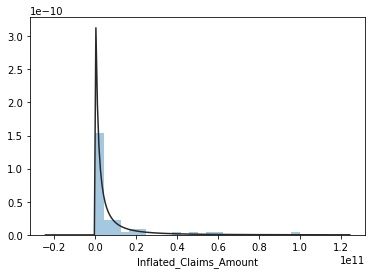

Inflated_Claims_Amount                              \
Year_Only_Lag                      0             1             2   
Insured_Year                                                       
2008                    4.266076e+08  1.544116e+09  1.772678e+09   
2009                    6.952918e+07  4.585009e+08  3.248265e+08   
2010                    1.433187e+09  2.271471e+10  1.465143e+09   
2011                    3.083895e+08  8.970770e+09  1.668904e+10   
2012                    1.976978e+08  9.785075e+09  6.447971e+09   
2013                    6.811658e+08  2.935456e+09  8.821710e+08   
2014                    3.447906e+09  1.168263e+09  1.963940e+09   
2015                    1.054836e+09  5.552565e+10  1.067904e+10   
2016                    4.579400e+10  2.203860e+10           NaN   
2017                    3.911162e+10           NaN           NaN   

                                                                       \
Year_Only_Lag             3             4             5             6   
Insured_Year                                                            
2008           3.709944e+09  2.668210e+09  5.232102e+08  1.456636e+09   
2009           3.540582e+09  1.411819e+09  1.617223e+09  3.754705e+09   
2010           4.953021e+08  2.414328e+09  6.127487e+08  1.004837e+09   
2011           1.256311e+09  9.824361e+09  9.977296e+10  7.592073e+09   
2012           6.644903e+09  1.311095e+10  4.311913e+09           NaN   
2013           9.610086e+09  1.699775e+10           NaN           NaN   
2014           6.718097e+09           NaN           NaN           NaN   
2015                    NaN           NaN           NaN           NaN   
2016                    NaN           NaN           NaN           NaN   
2017                    NaN           NaN           NaN           NaN   

                                                         
Year_Only_Lag             7             8             9  
Insured_Year                                             
2008           6.029563e+08  4.176674e+09  1.130348e+09  
2009           1.436601e+09  5.899089e+10           NaN  
2010           2.670382e+09           NaN           NaN  
2011                    NaN           NaN           NaN  
2012                    NaN           NaN           NaN  
2013                    NaN           NaN           NaN  
2014                    NaN           NaN           NaN  
2015                    NaN           NaN           NaN  
2016                    NaN           NaN           NaN  
2017                    NaN           NaN           NaN

In [151]:
# Incremental Claims Amount
# Inflated
py_triangle_inflated = pd.pivot_table(py_data, index=["Insured_Year"], columns=["Year_Only_Lag"], values=["Inflated_Claims_Amount"])
sns.distplot(py_data['Inflated_Claims_Amount'], kde=False, fit=stats.lognorm) # norm, pareto, loggamma, gompertz
plt.show()
display(py_triangle_inflated)

/var/folders/4y/r8t245md0712rsd6jcyf8qn40000gn/T/ipykernel_33754/2948027696.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(py_data['Claims_Amount'], kde=False, fit=stats.lognorm) # norm, pareto, loggamma, gompertz


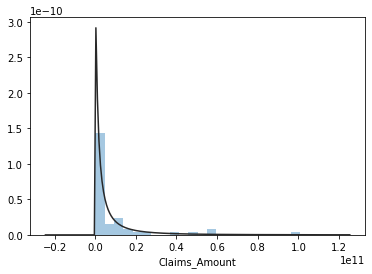

Claims_Amount                                            \
Year_Only_Lag             0             1             2             3   
Insured_Year                                                            
2008           5.414635e+08  1.885603e+09  2.181758e+09  4.352050e+09   
2009           8.490583e+07  5.643088e+08  3.810465e+08  3.949111e+09   
2010           1.763923e+09  2.664610e+10  1.634198e+09  5.334023e+08   
2011           3.617646e+08  1.000586e+10  1.797282e+10  1.316711e+09   
2012           2.205091e+08  1.053777e+10  6.757969e+09  6.836583e+09   
2013           7.335631e+08  3.076584e+09  9.076183e+08  9.702490e+09   
2014           3.613671e+09  1.201963e+09  1.982824e+09  6.718097e+09   
2015           1.085264e+09  5.605955e+10  1.067904e+10           NaN   
2016           4.623433e+10  2.203860e+10           NaN           NaN   
2017           3.911162e+10           NaN           NaN           NaN   

                                                                       \
Year_Only_Lag             4             5             6             7   
Insured_Year                                                            
2008           2.976080e+09  5.634571e+08  1.526666e+09  6.203493e+08   
2009           1.520421e+09  1.694974e+09  3.863014e+09  1.450415e+09   
2010           2.530402e+09  6.304242e+08  1.014499e+09  2.670382e+09   
2011           1.010776e+10  1.007323e+11  7.592073e+09           NaN   
2012           1.323702e+10  4.311913e+09           NaN           NaN   
2013           1.699775e+10           NaN           NaN           NaN   
2014                    NaN           NaN           NaN           NaN   
2015                    NaN           NaN           NaN           NaN   
2016                    NaN           NaN           NaN           NaN   
2017                    NaN           NaN           NaN           NaN   

                                           
Year_Only_Lag             8             9  
Insured_Year                               
2008           4.216834e+09  1.130348e+09  
2009           5.899089e+10           NaN  
2010                    NaN           NaN  
2011                    NaN           NaN  
2012                    NaN           NaN  
2013                    NaN           NaN  
2014                    NaN           NaN  
2015                    NaN           NaN  
2016                    NaN           NaN  
2017                    NaN           NaN

In [152]:
# Incremental Claims Amount
# Non-Inflated
py_triangle = pd.pivot_table(py_data, index=["Insured_Year"], columns=["Year_Only_Lag"], values=["Claims_Amount"])
sns.distplot(py_data['Claims_Amount'], kde=False, fit=stats.lognorm) # norm, pareto, loggamma, gompertz
plt.show()
display(py_triangle)

/var/folders/4y/r8t245md0712rsd6jcyf8qn40000gn/T/ipykernel_33754/3968279318.py:22: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(2, figsize=(10,5))


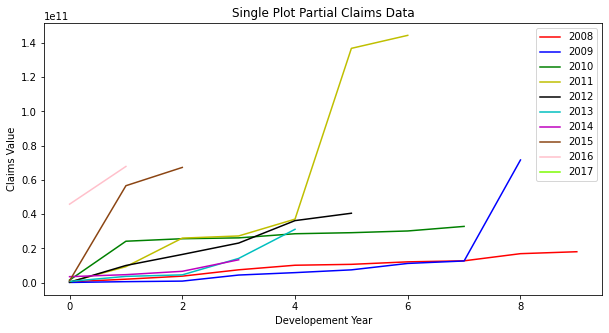

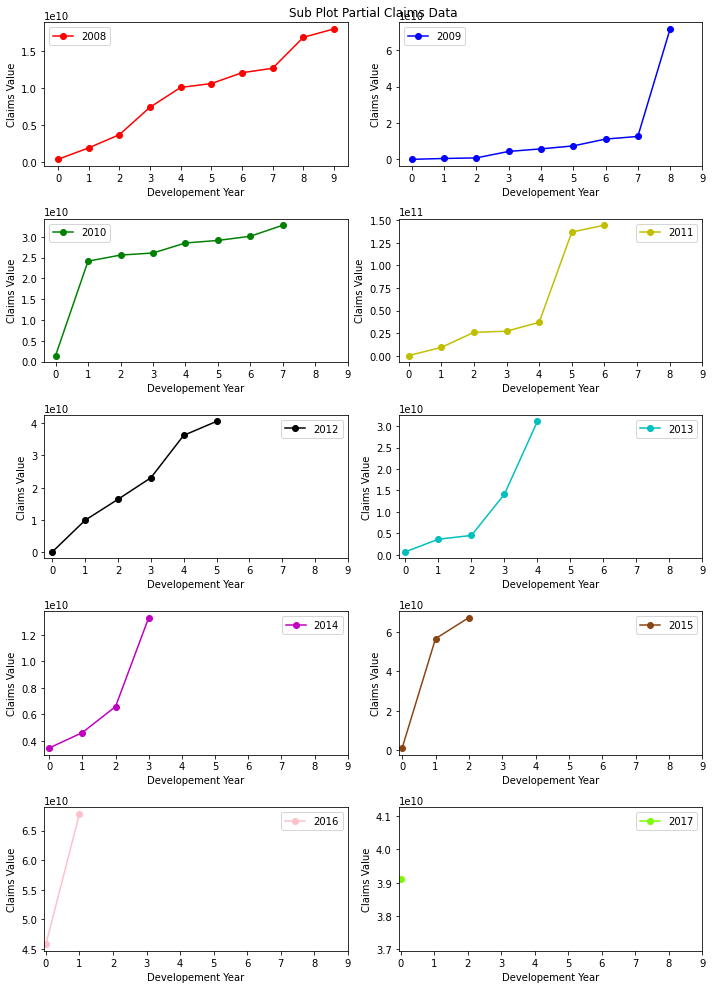

Inflated_cumsum                                            \
Year_Only_Lag               0             1             2             3   
Insured_Year                                                              
2008             4.266076e+08  1.970723e+09  3.743402e+09  7.453345e+09   
2009             6.952918e+07  5.280301e+08  8.528566e+08  4.393439e+09   
2010             1.433187e+09  2.414790e+10  2.561304e+10  2.610834e+10   
2011             3.083895e+08  9.279160e+09  2.596820e+10  2.722451e+10   
2012             1.976978e+08  9.982773e+09  1.643074e+10  2.307565e+10   
2013             6.811658e+08  3.616622e+09  4.498793e+09  1.410888e+10   
2014             3.447906e+09  4.616169e+09  6.580109e+09  1.329821e+10   
2015             1.054836e+09  5.658048e+10  6.725953e+10           NaN   
2016             4.579400e+10  6.783260e+10           NaN           NaN   
2017             3.911162e+10           NaN           NaN           NaN   

                                                                       \
Year_Only_Lag             4             5             6             7   
Insured_Year                                                            
2008           1.012156e+10  1.064477e+10  1.210140e+10  1.270436e+10   
2009           5.805258e+09  7.422481e+09  1.117719e+10  1.261379e+10   
2010           2.852267e+10  2.913542e+10  3.014026e+10  3.281064e+10   
2011           3.704888e+10  1.368218e+11  1.444139e+11           NaN   
2012           3.618660e+10  4.049851e+10           NaN           NaN   
2013           3.110663e+10           NaN           NaN           NaN   
2014                    NaN           NaN           NaN           NaN   
2015                    NaN           NaN           NaN           NaN   
2016                    NaN           NaN           NaN           NaN   
2017                    NaN           NaN           NaN           NaN   

                                           
Year_Only_Lag             8             9  
Insured_Year                               
2008           1.688103e+10  1.801138e+10  
2009           7.160468e+10           NaN  
2010                    NaN           NaN  
2011                    NaN           NaN  
2012                    NaN           NaN  
2013                    NaN           NaN  
2014                    NaN           NaN  
2015                    NaN           NaN  
2016                    NaN           NaN  
2017                    NaN           NaN

In [153]:
# Cumulative Claims Amount
# Inflated
py_triangle_cum_inflated = pd.pivot_table(py_data, index=["Insured_Year"], columns=["Year_Only_Lag"], values=["Inflated_cumsum"])
SinglePlotPartialClaims(DataFrameName=py_data, InsuredYearColumn='Insured_Year', LagYearColumn='Year_Only_Lag', ValueColumn='Inflated_cumsum')
SubPlotPartialClaims(DataFrameName=py_data, InsuredYearColumn='Insured_Year', LagYearColumn='Year_Only_Lag', ValueColumn='Inflated_cumsum')
display(py_triangle_cum_inflated)

/var/folders/4y/r8t245md0712rsd6jcyf8qn40000gn/T/ipykernel_33754/3968279318.py:22: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(2, figsize=(10,5))


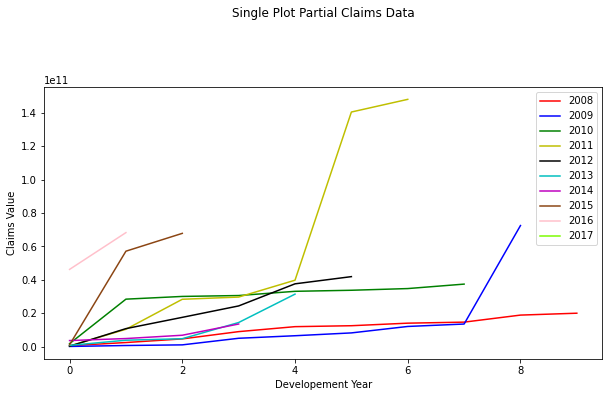

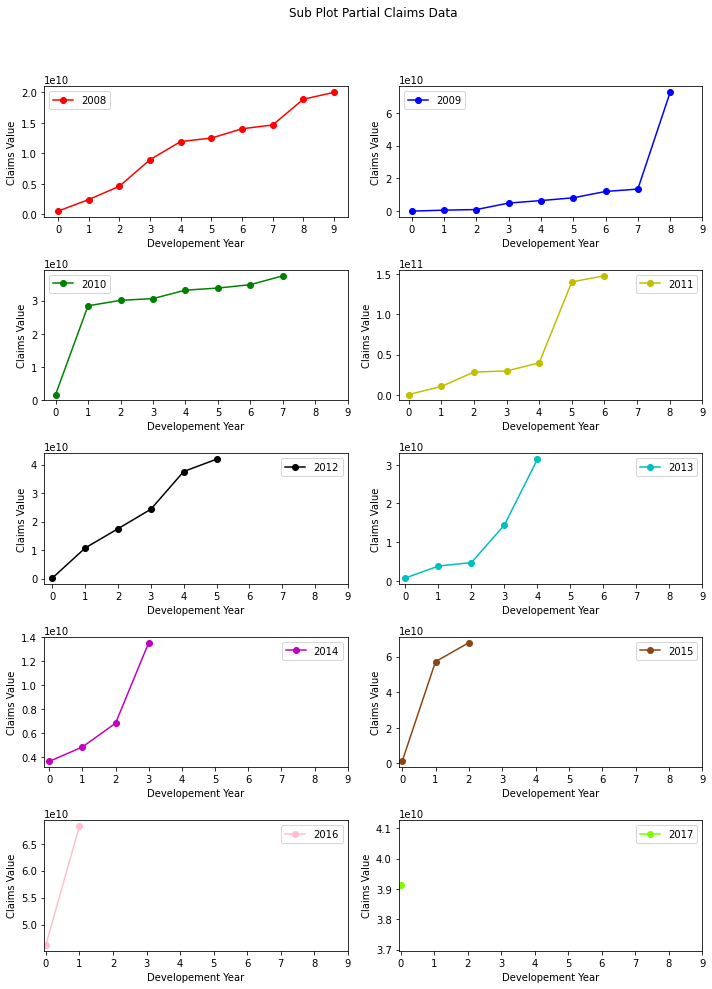

cumsum                                            \
Year_Only_Lag             0             1             2             3   
Insured_Year                                                            
2008           5.414635e+08  2.427066e+09  4.608824e+09  8.960874e+09   
2009           8.490583e+07  6.492146e+08  1.030261e+09  4.979372e+09   
2010           1.763923e+09  2.841002e+10  3.004422e+10  3.057762e+10   
2011           3.617646e+08  1.036762e+10  2.834044e+10  2.965715e+10   
2012           2.205091e+08  1.075828e+10  1.751625e+10  2.435283e+10   
2013           7.335631e+08  3.810147e+09  4.717765e+09  1.442026e+10   
2014           3.613671e+09  4.815634e+09  6.798458e+09  1.351655e+10   
2015           1.085264e+09  5.714481e+10  6.782385e+10           NaN   
2016           4.623433e+10  6.827293e+10           NaN           NaN   
2017           3.911162e+10           NaN           NaN           NaN   

                                                                       \
Year_Only_Lag             4             5             6             7   
Insured_Year                                                            
2008           1.193695e+10  1.250041e+10  1.402708e+10  1.464743e+10   
2009           6.499793e+09  8.194767e+09  1.205778e+10  1.350820e+10   
2010           3.310803e+10  3.373845e+10  3.475295e+10  3.742333e+10   
2011           3.976491e+10  1.404972e+11  1.480893e+11           NaN   
2012           3.758985e+10  4.190177e+10           NaN           NaN   
2013           3.141801e+10           NaN           NaN           NaN   
2014                    NaN           NaN           NaN           NaN   
2015                    NaN           NaN           NaN           NaN   
2016                    NaN           NaN           NaN           NaN   
2017                    NaN           NaN           NaN           NaN   

                                           
Year_Only_Lag             8             9  
Insured_Year                               
2008           1.886426e+10  1.999461e+10  
2009           7.249908e+10           NaN  
2010                    NaN           NaN  
2011                    NaN           NaN  
2012                    NaN           NaN  
2013                    NaN           NaN  
2014                    NaN           NaN  
2015                    NaN           NaN  
2016                    NaN           NaN  
2017                    NaN           NaN

In [154]:
# Cumulative Claims Amount
# Non-Inflated
py_triangle_cum = pd.pivot_table(py_data, index=["Insured_Year"], columns=["Year_Only_Lag"], values=["cumsum"])
SinglePlotPartialClaims(DataFrameName=py_data, InsuredYearColumn='Insured_Year', LagYearColumn='Year_Only_Lag', ValueColumn='cumsum')
SubPlotPartialClaims(DataFrameName=py_data, InsuredYearColumn='Insured_Year', LagYearColumn='Year_Only_Lag', ValueColumn='cumsum')
display(py_triangle_cum)

/var/folders/4y/r8t245md0712rsd6jcyf8qn40000gn/T/ipykernel_33754/3968279318.py:22: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(2, figsize=(10,5))


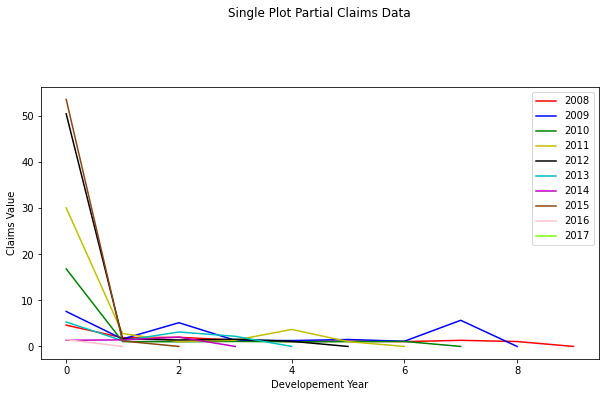

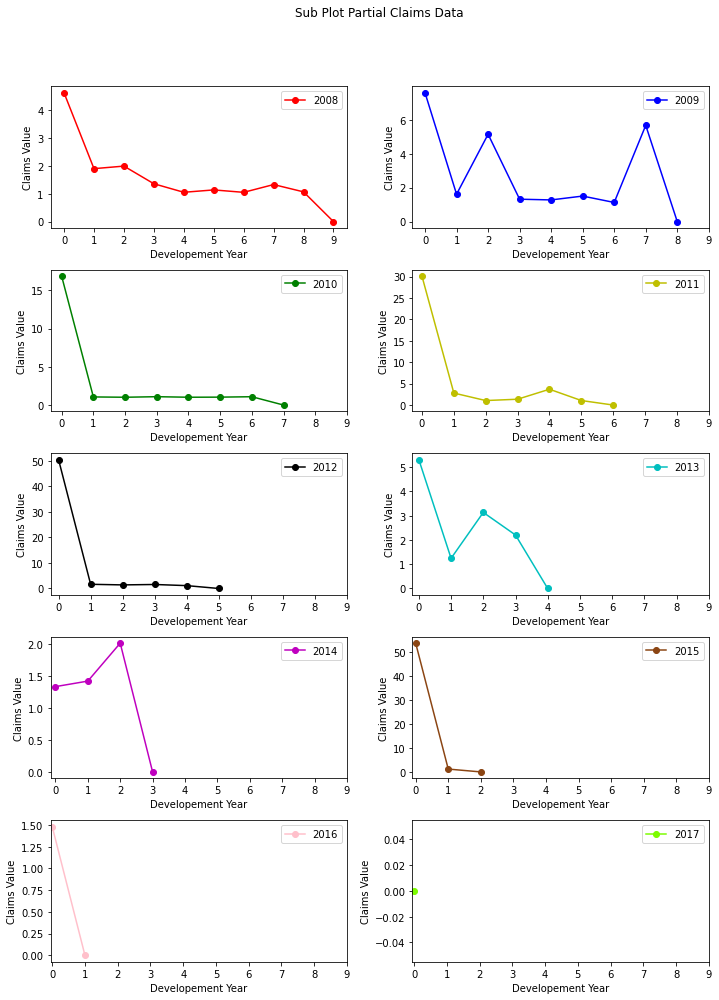

Inflated_LossDF                                          \
Year_Only_Lag               0         1         2         3         4   
Insured_Year                                                            
2008                 4.619523  1.899506  1.991062  1.357988  1.051693   
2009                 7.594366  1.615167  5.151439  1.321347  1.278579   
2010                16.849089  1.060674  1.019338  1.092473  1.021483   
2011                30.089091  2.798551  1.048379  1.360865  3.693009   
2012                50.495111  1.645910  1.404419  1.568173  1.119158   
2013                 5.309459  1.243921  3.136148  2.204756  0.000000   
2014                 1.338832  1.425448  2.020970  0.000000       NaN   
2015                53.639113  1.188741  0.000000       NaN       NaN   
2016                 1.481255  0.000000       NaN       NaN       NaN   
2017                 0.000000       NaN       NaN       NaN       NaN   

                                                           
Year_Only_Lag         5         6         7        8    9  
Insured_Year                                               
2008           1.136841  1.049825  1.328759  1.06696  0.0  
2009           1.505856  1.128530  5.676699  0.00000  NaN  
2010           1.034489  1.088599  0.000000      NaN  NaN  
2011           1.055489  0.000000       NaN      NaN  NaN  
2012           0.000000       NaN       NaN      NaN  NaN  
2013                NaN       NaN       NaN      NaN  NaN  
2014                NaN       NaN       NaN      NaN  NaN  
2015                NaN       NaN       NaN      NaN  NaN  
2016                NaN       NaN       NaN      NaN  NaN  
2017                NaN       NaN       NaN      NaN  NaN

In [155]:
# Individual Loss Development factors
# Inflated
py_InflatedLossDF_triangle = pd.pivot_table(py_data, index=["Insured_Year"], columns=["Year_Only_Lag"], values=["Inflated_LossDF"])
SinglePlotPartialClaims(DataFrameName=py_data, InsuredYearColumn='Insured_Year', LagYearColumn='Year_Only_Lag', ValueColumn='Inflated_LossDF')
SubPlotPartialClaims(DataFrameName=py_data, InsuredYearColumn='Insured_Year', LagYearColumn='Year_Only_Lag', ValueColumn='Inflated_LossDF')
display(py_InflatedLossDF_triangle)

/var/folders/4y/r8t245md0712rsd6jcyf8qn40000gn/T/ipykernel_33754/3968279318.py:22: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(2, figsize=(10,5))


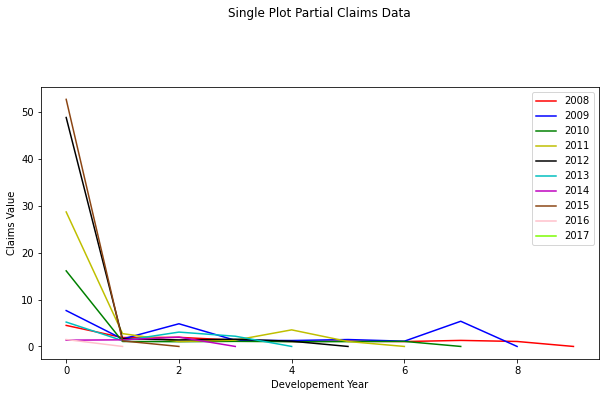

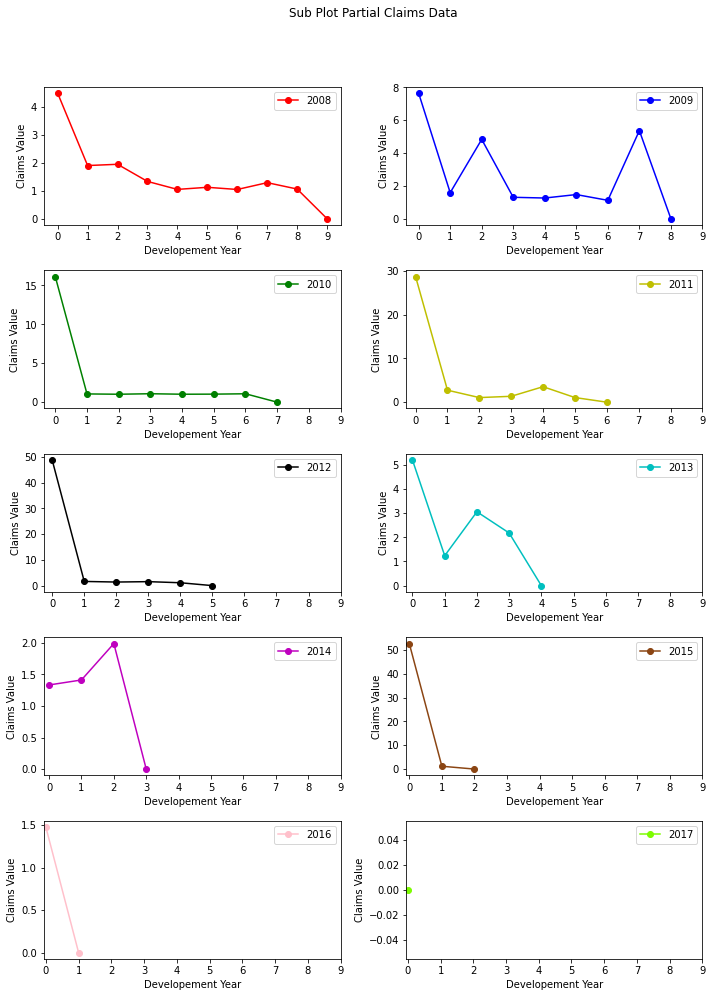

LossDF                                                    \
Year_Only_Lag          0         1         2         3         4         5   
Insured_Year                                                                 
2008            4.482420  1.898928  1.944286  1.332119  1.047203  1.122129   
2009            7.646291  1.586935  4.833116  1.305344  1.260774  1.471400   
2010           16.106163  1.057522  1.017754  1.082753  1.019041  1.030070   
2011           28.658480  2.733552  1.046460  1.340820  3.533196  1.054037   
2012           48.788383  1.628164  1.390299  1.543552  1.114709  0.000000   
2013            5.194027  1.238211  3.056586  2.178742  0.000000       NaN   
2014            1.332615  1.411747  1.988180  0.000000       NaN       NaN   
2015           52.655204  1.186877  0.000000       NaN       NaN       NaN   
2016            1.476672  0.000000       NaN       NaN       NaN       NaN   
2017            0.000000       NaN       NaN       NaN       NaN       NaN   

                                                 
Year_Only_Lag         6         7        8    9  
Insured_Year                                     
2008           1.044225  1.287889  1.05992  0.0  
2009           1.120289  5.367044  0.00000  NaN  
2010           1.076839  0.000000      NaN  NaN  
2011           0.000000       NaN      NaN  NaN  
2012                NaN       NaN      NaN  NaN  
2013                NaN       NaN      NaN  NaN  
2014                NaN       NaN      NaN  NaN  
2015                NaN       NaN      NaN  NaN  
2016                NaN       NaN      NaN  NaN  
2017                NaN       NaN      NaN  NaN

In [156]:
# Individual Loss Development factors
# Non-Inflated
py_LossDF_triangle = pd.pivot_table(py_data, index=["Insured_Year"], columns=["Year_Only_Lag"], values=["LossDF"])
SinglePlotPartialClaims(DataFrameName=py_data, InsuredYearColumn='Insured_Year', LagYearColumn='Year_Only_Lag', ValueColumn='LossDF')
SubPlotPartialClaims(DataFrameName=py_data, InsuredYearColumn='Insured_Year', LagYearColumn='Year_Only_Lag', ValueColumn='LossDF')
display(py_LossDF_triangle)

In [168]:
# Create a Temp Df of Predicted Years & LagYears rates
columns_3 = ['InsuredYear', 'PredictedYear_Only_Lag',
             'Previous_cumsum', 'Predicted_cumsum', 'Predicted_Incremental',
             'Previous_Inflated_cumsum', 'Predicted_Inflated_cumsum', 'Predicted_Inflated_Incremental']
Temp_df = pd.DataFrame(columns=columns_3)
# +1 due to 31 Dec 2017 (also not a Bday) & +1 due to range exlusion of last value cap
InsuredYr = list(range(YearStartCap + 1, YearEndCap + 1, 1))  # [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Temp_df['InsuredYear'] = InsuredYr
Lags = list(range(0, YearEndCap - YearStartCap, 1))  # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Temp_df['PredictedYear_Only_Lag'] = Lags

# Establish Predicted data-frame
Predicted_df = pd.DataFrame(columns=columns_3)

In [173]:
# Coordinates of predicted Insured Years & Lag Years
i = 0 # For loop impute indexing
for row in range(0, len(Temp_df['InsuredYear'])):
    BaseYr = Temp_df.loc[row, 'InsuredYear']
    for lag in range(0, len(Temp_df['PredictedYear_Only_Lag'])):
        LagYr = Temp_df.loc[lag, 'PredictedYear_Only_Lag']
        P_yr = BaseYr + Temp_df.loc[lag, 'PredictedYear_Only_Lag']
        if P_yr > YearEndCap:
            Predicted_df.loc[i, 'InsuredYear'] = BaseYr
            Predicted_df.loc[i, 'PredictedYear_Only_Lag'] = LagYr
            i += 1
        else:
            pass

In [174]:
Predicted_df.head()

,InsuredYear,PredictedYear_Only_Lag,Previous_cumsum,Predicted_cumsum,Predicted_Incremental,Previous_Inflated_cumsum,Predicted_Inflated_cumsum,Predicted_Inflated_Incremental
0,2009,9,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,8,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,9,NaN,NaN,NaN,NaN,NaN,NaN
3,2011,7,NaN,NaN,NaN,NaN,NaN,NaN
4,2011,8,NaN,NaN,NaN,NaN,NaN,NaN


In [178]:
# Impute latest cumulative amounts available
# Inflated
for row in range(0, len(Predicted_df)):
    Base = Predicted_df.loc[row, 'InsuredYear']
    Lag = Predicted_df.loc[row, 'PredictedYear_Only_Lag']
    PredYr = Base + Lag

    if Base == YearEndCap:
        PrevInflatedCumSum = py_data.loc[(py_data['Insured_Year'] == Base), 'Inflated_cumsum'].values[0]

    else:
        if PredYr > YearEndCap or len(py_data.loc[(py_data['Insured_Year'] == Base) & (py_data['Year_Only_Lag'] == Lag - 1), 'Inflated_cumsum']) == 0:
            MaxLag = py_data.loc[(py_data['Insured_Year'] == Base), 'Year_Only_Lag'].max()
            PrevInflatedCumSum = py_data.loc[(py_data['Insured_Year'] == Base) & (py_data['Year_Only_Lag'] == MaxLag), 'Inflated_cumsum'].values[0]

        else:
            PrevInflatedCumSum = py_data.loc[(py_data['Insured_Year'] == Base) & (py_data['Year_Only_Lag'] == Lag - 1), 'Inflated_cumsum'].values[0]

    Predicted_df.loc[row, 'Previous_Inflated_cumsum'] = PrevInflatedCumSum

In [179]:
Predicted_df.head()

,InsuredYear,PredictedYear_Only_Lag,Previous_cumsum,Predicted_cumsum,Predicted_Incremental,Previous_Inflated_cumsum,Predicted_Inflated_cumsum,Predicted_Inflated_Incremental
0,2009,9,NaN,NaN,NaN,71604675403.726028,NaN,NaN
1,2010,8,NaN,NaN,NaN,32810638680.048031,NaN,NaN
2,2010,9,NaN,NaN,NaN,32810638680.048031,NaN,NaN
3,2011,7,NaN,NaN,NaN,144413911732.509064,NaN,NaN
4,2011,8,NaN,NaN,NaN,144413911732.509064,NaN,NaN


In [181]:
# Impute latest cumulative amounts available
# Non-Inflated
for row in range(0, len(Predicted_df)):
    Base = Predicted_df.loc[row, 'InsuredYear']
    Lag = Predicted_df.loc[row, 'PredictedYear_Only_Lag']
    PredYr = Base + Lag

    if Base == YearEndCap:
        PrevCumSum = py_data.loc[(py_data['Insured_Year'] == Base), 'cumsum'].values[0]

    else:
        if PredYr > YearEndCap or len(
                py_data.loc[(py_data['Insured_Year'] == Base) & (py_data['Year_Only_Lag'] == Lag - 1), 'cumsum']) == 0:
            MaxLag = py_data.loc[(py_data['Insured_Year'] == Base), 'Year_Only_Lag'].max()
            PrevCumSum = py_data.loc[(py_data['Insured_Year'] == Base) & (py_data['Year_Only_Lag'] == MaxLag), 'cumsum'].values[0]

        else:
            PrevCumSum = py_data.loc[(py_data['Insured_Year'] == Base) & (py_data['Year_Only_Lag'] == Lag - 1), 'cumsum'].values[0]

    Predicted_df.loc[row, 'Previous_cumsum'] = PrevCumSum

In [182]:
Predicted_df.head()

,InsuredYear,PredictedYear_Only_Lag,Previous_cumsum,Predicted_cumsum,Predicted_Incremental,Previous_Inflated_cumsum,Predicted_Inflated_cumsum,Predicted_Inflated_Incremental
0,2009,9,72499083495.133469,NaN,NaN,71604675403.726028,NaN,NaN
1,2010,8,37423332170.61116,NaN,NaN,32810638680.048031,NaN,NaN
2,2010,9,37423332170.61116,NaN,NaN,32810638680.048031,NaN,NaN
3,2011,7,148089298275.550385,NaN,NaN,144413911732.509064,NaN,NaN
4,2011,8,148089298275.550385,NaN,NaN,144413911732.509064,NaN,NaN


In [183]:
columns_4 = ['Year_Only_Lag',
             'SimpleMeanLossDF', 'VolWtdLossDF',
             'CumToUlt_SimpleMeanLossDF', 'CumToUlt_VolWtdLossDF',
             'SimpleMeanLossDF_5year', 'VolWtdLossDF_5year',
             'SimpleMeanLossDF_3year', 'VolWtdLossDF_3year',
             'SelectLossDF'
             'Inflated_SimpleMeanLossDF', 'Inflated_VolWtdLossDF',
             'Inflated_CumToUlt_SimpleMeanLossDF', 'Inflated_CumToUlt_VolWtdLossDF',
             'Inflated_SimpleMeanLossDF_5year', 'Inflated_VolWtdLossDF_5year',
             'Inflated_SimpleMeanLossDF_3year', 'Inflated_VolWtdLossDF_3year',
             'Inflated_SelectLossDF']
LossDF_df = pd.DataFrame(columns=columns_4)
Lags = list(range(0, YearEndCap-YearStartCap, 1))
LossDF_df['Year_Only_Lag'] = Lags
display(LossDF_df)

,Year_Only_Lag,SimpleMeanLossDF,VolWtdLossDF,CumToUlt_SimpleMeanLossDF,CumToUlt_VolWtdLossDF,SimpleMeanLossDF_5year,VolWtdLossDF_5year,SimpleMeanLossDF_3year,VolWtdLossDF_3year,SelectLossDFInflated_SimpleMeanLossDF,Inflated_VolWtdLossDF,Inflated_CumToUlt_SimpleMeanLossDF,Inflated_CumToUlt_VolWtdLossDF,Inflated_SimpleMeanLossDF_5year,Inflated_VolWtdLossDF_5year,Inflated_SimpleMeanLossDF_3year,Inflated_VolWtdLossDF_3year,Inflated_SelectLossDF
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/var/folders/4y/r8t245md0712rsd6jcyf8qn40000gn/T/ipykernel_33754/3806140736.py:10: RuntimeWarning: invalid value encountered in scalar divide
  VolWtdLossDF = Deno / Neum


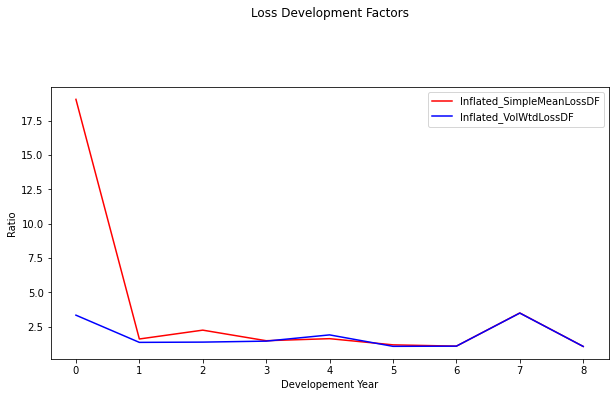

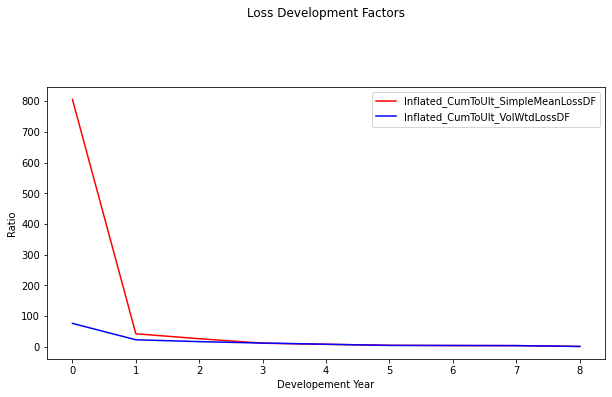

,Inflated_SimpleMeanLossDF,Inflated_VolWtdLossDF,Inflated_CumToUlt_SimpleMeanLossDF,Inflated_CumToUlt_VolWtdLossDF
0,19.046204,3.342883,806.138707,76.194485
1,1.609740,1.363296,42.325425,22.793048
2,2.253108,1.38208,26.293335,16.719074
3,1.484267,1.453552,11.669807,12.097034
4,1.632784,1.907831,7.862337,8.322397
5,1.183168,1.075035,4.815294,4.36223
6,1.088985,1.08817,4.069830,4.057757
7,3.502729,3.494952,3.737271,3.728973
8,1.066960,1.06696,1.066960,1.06696
9,NaN,NaN,NaN,NaN


In [ ]:
# Inflated
i=0
for lag in range(0, len(Temp_df['PredictedYear_Only_Lag'])):
    lagyr = Temp_df.loc[lag, 'PredictedYear_Only_Lag']
    SimpleMeanLossDF = py_data.loc[py_data['Year_Only_Lag'] == lagyr, 'Inflated_LossDF'][:-1].mean()
    LossDF_df.loc[i, 'Inflated_SimpleMeanLossDF'] = SimpleMeanLossDF
    # Volume Weighted
    Deno = py_data.loc[py_data['Year_Only_Lag'] == (lagyr + 1), 'Inflated_cumsum'].sum()
    Neum = py_data.loc[py_data['Year_Only_Lag'] == lagyr, 'Inflated_cumsum'][:-1].sum()
    VolWtdLossDF = Deno / Neum
    LossDF_df.loc[i, 'Inflated_VolWtdLossDF'] = VolWtdLossDF
    i += 1

# [::-1] to flip or invert the row order
LossDF_df['Inflated_CumToUlt_SimpleMeanLossDF']=LossDF_df['Inflated_SimpleMeanLossDF'][::-1].cumprod()
LossDF_df['Inflated_CumToUlt_VolWtdLossDF']=LossDF_df['Inflated_VolWtdLossDF'][::-1].cumprod()

SinglePlotLDF(DataFrameName=LossDF_df, Columns=['Inflated_SimpleMeanLossDF', 'Inflated_VolWtdLossDF'])
SinglePlotLDF(DataFrameName=LossDF_df, Columns=['Inflated_CumToUlt_SimpleMeanLossDF', 'Inflated_CumToUlt_VolWtdLossDF'])
display(LossDF_df[['Inflated_SimpleMeanLossDF', 'Inflated_VolWtdLossDF', 'Inflated_CumToUlt_SimpleMeanLossDF', 'Inflated_CumToUlt_VolWtdLossDF']])

/var/folders/4y/r8t245md0712rsd6jcyf8qn40000gn/T/ipykernel_33754/2470668934.py:12: RuntimeWarning: invalid value encountered in scalar divide
  VolWtdLossDF = Deno / Neum


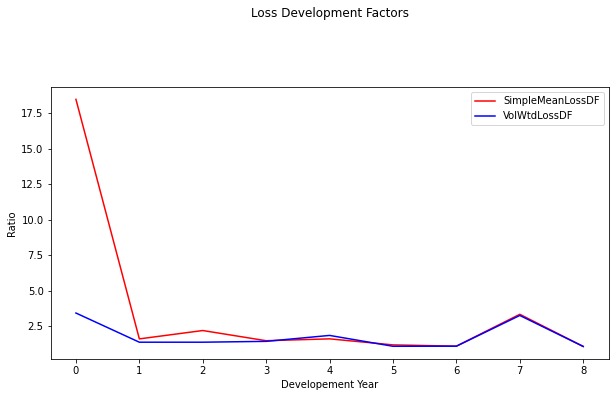

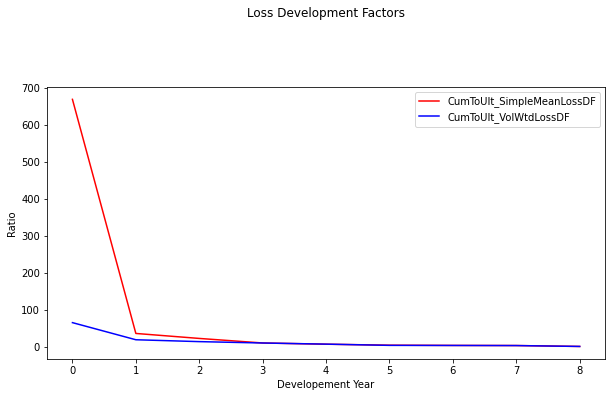

,SimpleMeanLossDF,VolWtdLossDF,CumToUlt_SimpleMeanLossDF,CumToUlt_VolWtdLossDF
0,18.482251,3.416139,668.427184,65.380808
1,1.592742,1.358982,36.165898,19.138804
2,2.182383,1.359014,22.70669,14.083194
3,1.463888,1.419391,10.404538,10.362806
4,1.594985,1.837343,7.107467,7.300881
5,1.169409,1.071801,4.456135,3.973609
6,1.080451,1.077931,3.810587,3.707412
7,3.327467,3.244941,3.526849,3.439379
8,1.05992,1.05992,1.05992,1.05992
9,NaN,NaN,NaN,NaN


In [199]:
# Non-Inflated
i=0
for lag in range(0, len(Temp_df['PredictedYear_Only_Lag'])):
    lagyr = Temp_df.loc[lag, 'PredictedYear_Only_Lag']
    # Simple Mean
    # due to 0 input so exlude last value
    SimpleMeanLossDF = py_data.loc[py_data['Year_Only_Lag'] == lagyr, 'LossDF'][:-1].mean()
    LossDF_df.loc[i, 'SimpleMeanLossDF'] = SimpleMeanLossDF
    # Volume Weighted
    Deno = py_data.loc[py_data['Year_Only_Lag'] == (lagyr + 1), 'cumsum'].sum()
    Neum = py_data.loc[py_data['Year_Only_Lag'] == lagyr, 'cumsum'][:-1].sum()
    VolWtdLossDF = Deno / Neum
    LossDF_df.loc[i, 'VolWtdLossDF'] = VolWtdLossDF
    i += 1

# [::-1] to flip or invert the row order
LossDF_df['CumToUlt_SimpleMeanLossDF']=LossDF_df['SimpleMeanLossDF'][::-1].cumprod()
LossDF_df['CumToUlt_VolWtdLossDF']=LossDF_df['VolWtdLossDF'][::-1].cumprod()

SinglePlotLDF(DataFrameName=LossDF_df, Columns=['SimpleMeanLossDF', 'VolWtdLossDF'])
SinglePlotLDF(DataFrameName=LossDF_df, Columns=['CumToUlt_SimpleMeanLossDF', 'CumToUlt_VolWtdLossDF'])
display(LossDF_df[['SimpleMeanLossDF', 'VolWtdLossDF', 'CumToUlt_SimpleMeanLossDF', 'CumToUlt_VolWtdLossDF']])


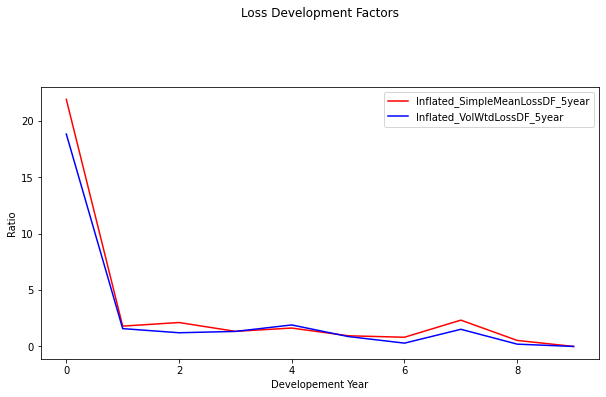

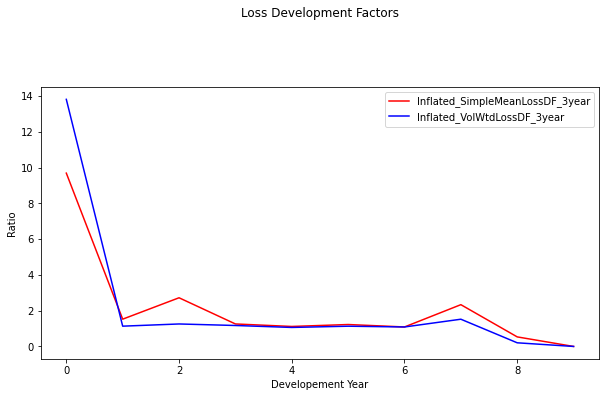

,Inflated_SimpleMeanLossDF_5year,Inflated_VolWtdLossDF_5year,Inflated_SimpleMeanLossDF_3year,Inflated_VolWtdLossDF_3year
0,21.929436,18.850445,9.687659,13.811393
1,1.803962,1.581583,1.525116,1.1337
2,2.122927,1.2155,2.720613,1.256405
3,1.340169,1.333461,1.25727,1.171106
4,1.632784,1.907831,1.117252,1.06194
5,0.946535,0.881125,1.225728,1.131691
6,0.816738,0.293828,1.088985,1.08817
7,2.335153,1.522236,2.335153,1.522236
8,0.53348,0.203551,0.53348,0.203551
9,0.0,0.0,0.0,0.0


In [ ]:
# Inflated
i=0
for lag in range(0, len(Temp_df['PredictedYear_Only_Lag'])):
    lagyr = Temp_df.loc[lag, 'PredictedYear_Only_Lag']
    Year_A = 5   # 5 Year
    SimpleMeanLossDF_Ayear = py_data.loc[py_data['Year_Only_Lag'] == lagyr, 'Inflated_LossDF'][:Year_A].mean()
    LossDF_df.loc[i, 'Inflated_SimpleMeanLossDF_5year'] = SimpleMeanLossDF_Ayear
    Year_B = 3   # 3 Year
    SimpleMeanLossDF_Byear = py_data.loc[py_data['Year_Only_Lag'] == lagyr, 'Inflated_LossDF'][:Year_B].mean()
    LossDF_df.loc[i, 'Inflated_SimpleMeanLossDF_3year'] = SimpleMeanLossDF_Byear
    # Volume Weighted
    Deno_A = py_data.loc[py_data['Year_Only_Lag'] == (lagyr + 1), 'Inflated_cumsum'][:Year_A].sum()
    Neum_A = py_data.loc[py_data['Year_Only_Lag'] == lagyr, 'Inflated_cumsum'][:Year_A].sum()
    VolWtdLossDF_A = Deno_A / Neum_A
    LossDF_df.loc[i, 'Inflated_VolWtdLossDF_5year'] = VolWtdLossDF_A
    Deno_B = py_data.loc[py_data['Year_Only_Lag'] == (lagyr + 1), 'Inflated_cumsum'][:Year_B].sum()
    Neum_B = py_data.loc[py_data['Year_Only_Lag'] == lagyr, 'Inflated_cumsum'][:Year_B].sum()
    VolWtdLossDF_B = Deno_B / Neum_B
    LossDF_df.loc[i, 'Inflated_VolWtdLossDF_3year'] = VolWtdLossDF_B
    i += 1

SinglePlotLDF(DataFrameName=LossDF_df, Columns=['Inflated_SimpleMeanLossDF_5year', 'Inflated_VolWtdLossDF_5year'])
SinglePlotLDF(DataFrameName=LossDF_df, Columns=['Inflated_SimpleMeanLossDF_3year', 'Inflated_VolWtdLossDF_3year'])    
display(LossDF_df[['Inflated_SimpleMeanLossDF_5year', 'Inflated_VolWtdLossDF_5year', 'Inflated_SimpleMeanLossDF_3year', 'Inflated_VolWtdLossDF_3year']])

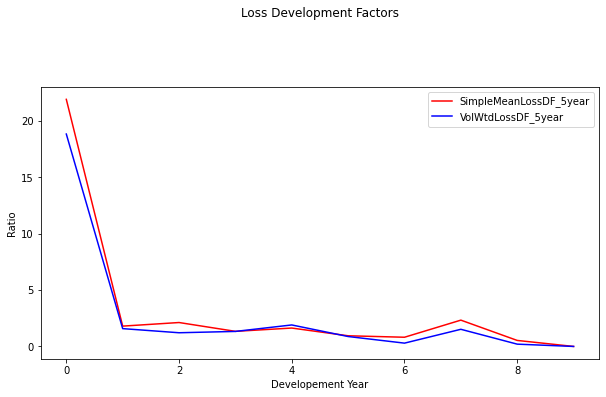

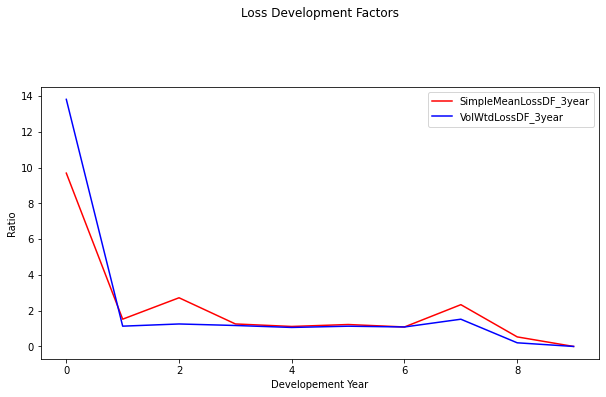

,SimpleMeanLossDF_5year,VolWtdLossDF_5year,SimpleMeanLossDF_3year,VolWtdLossDF_3year
0,21.929436,18.850445,9.687659,13.811393
1,1.803962,1.581583,1.525116,1.1337
2,2.122927,1.2155,2.720613,1.256405
3,1.340169,1.333461,1.25727,1.171106
4,1.632784,1.907831,1.117252,1.06194
5,0.946535,0.881125,1.225728,1.131691
6,0.816738,0.293828,1.088985,1.08817
7,2.335153,1.522236,2.335153,1.522236
8,0.53348,0.203551,0.53348,0.203551
9,0.0,0.0,0.0,0.0


In [201]:
# Non Inflated
i=0
for lag in range(0, len(Temp_df['PredictedYear_Only_Lag'])):
    lagyr = Temp_df.loc[lag, 'PredictedYear_Only_Lag']
    # Simple Mean
    Year_A = 5   # 5 Year
    SimpleMeanLossDF_Ayear = py_data.loc[py_data['Year_Only_Lag'] == lagyr, 'Inflated_LossDF'][:Year_A].mean()
    LossDF_df.loc[i, 'SimpleMeanLossDF_5year'] = SimpleMeanLossDF_Ayear
    Year_B = 3   # 3 Year
    SimpleMeanLossDF_Byear = py_data.loc[py_data['Year_Only_Lag'] == lagyr, 'Inflated_LossDF'][:Year_B].mean()
    LossDF_df.loc[i, 'SimpleMeanLossDF_3year'] = SimpleMeanLossDF_Byear
    # Volume Weighted
    Deno_A = py_data.loc[py_data['Year_Only_Lag'] == (lagyr + 1), 'Inflated_cumsum'][:Year_A].sum()
    Neum_A = py_data.loc[py_data['Year_Only_Lag'] == lagyr, 'Inflated_cumsum'][:Year_A].sum()
    VolWtdLossDF_A = Deno_A / Neum_A
    LossDF_df.loc[i, 'VolWtdLossDF_5year'] = VolWtdLossDF_A
    Deno_B = py_data.loc[py_data['Year_Only_Lag'] == (lagyr + 1), 'Inflated_cumsum'][:Year_B].sum()
    Neum_B = py_data.loc[py_data['Year_Only_Lag'] == lagyr, 'Inflated_cumsum'][:Year_B].sum()
    VolWtdLossDF_B = Deno_B / Neum_B
    LossDF_df.loc[i, 'VolWtdLossDF_3year'] = VolWtdLossDF_B
    i += 1

SinglePlotLDF(DataFrameName=LossDF_df, Columns=['SimpleMeanLossDF_5year', 'VolWtdLossDF_5year'])
SinglePlotLDF(DataFrameName=LossDF_df, Columns=['SimpleMeanLossDF_3year', 'VolWtdLossDF_3year'])
display(LossDF_df[['SimpleMeanLossDF_5year', 'VolWtdLossDF_5year', 'SimpleMeanLossDF_3year', 'VolWtdLossDF_3year']])

In [202]:
LossDF_df['Inflated_SelectLossDF'] = LossDF_df['Inflated_VolWtdLossDF']
LossDF_df['SelectLossDF'] = LossDF_df['VolWtdLossDF']

In [237]:
# Predict Cumulative Claim Amounts
# Inflated
# Set Equal for easy reference
Predicted_df['Predicted_Inflated_cumsum'] = Predicted_df['Previous_Inflated_cumsum']
lagyearlimit = (YearEndCap - YearStartCap) - 1
for row in range(0, len(Predicted_df)):
    PredLagYr = Predicted_df.loc[row, 'PredictedYear_Only_Lag']
    BaseInsuredYr = Predicted_df.loc[row, 'InsuredYear']
    MaxLagYr = py_data.loc[(py_data['Insured_Year'] == BaseInsuredYr), 'Year_Only_Lag'].max()
    for r in range(0, len(LossDF_df)):
        if (LossDF_df.loc[r, 'Year_Only_Lag'] == lagyearlimit):
            pass #x = x  # To avoid NaN
        elif (LossDF_df.loc[r, 'Year_Only_Lag'] == MaxLagYr):
            # LDF multiplication
            LDF = LossDF_df.loc[(LossDF_df['Year_Only_Lag'] >= MaxLagYr) & (LossDF_df['Year_Only_Lag'] <= (PredLagYr - 1)), 'Inflated_SelectLossDF'].prod()
            Predicted_df.loc[row, 'Predicted_Inflated_cumsum'] = Predicted_df.loc[row, 'Predicted_Inflated_cumsum'] * LDF
        else:
            pass
            

In [246]:
Predicted_df.head()

,InsuredYear,PredictedYear_Only_Lag,Previous_cumsum,Predicted_cumsum,Predicted_Incremental,Previous_Inflated_cumsum,Predicted_Inflated_cumsum,Predicted_Inflated_Incremental
0,2009,9,7.249908e+10,NaN,NaN,7.160468e+10,7.639930e+10,4.794624e+09
1,2010,8,3.742333e+10,NaN,NaN,3.281064e+10,1.146716e+11,8.186097e+10
2,2010,9,3.742333e+10,NaN,NaN,3.281064e+10,1.223500e+11,7.678372e+09
3,2011,7,1.480893e+11,NaN,NaN,1.444139e+11,1.571469e+11,1.273298e+10
4,2011,8,1.480893e+11,NaN,NaN,1.444139e+11,5.492209e+11,3.920740e+11


In [250]:
# Predict Cumulative Claim Amounts
# Non-Inflated
# Set Equal for easy reference
Predicted_df['Predicted_cumsum'] = Predicted_df['Previous_cumsum']
lagyearlimit = (YearEndCap - YearStartCap) - 1

for row in range(0, len(Predicted_df)):
    PredLagYr = Predicted_df.loc[row, 'PredictedYear_Only_Lag']
    BaseInsuredYr = Predicted_df.loc[row, 'InsuredYear']
    MaxLagYr = py_data.loc[(py_data['Insured_Year'] == BaseInsuredYr), 'Year_Only_Lag'].max()
    for r in range(0, len(LossDF_df)):
        if (LossDF_df.loc[r, 'Year_Only_Lag'] == lagyearlimit):
            pass
        elif (LossDF_df.loc[r, 'Year_Only_Lag'] == MaxLagYr):
            # LDF multiplication
            LDF = LossDF_df.loc[(LossDF_df['Year_Only_Lag'] >= MaxLagYr) & (LossDF_df['Year_Only_Lag'] <= (PredLagYr - 1)), 'SelectLossDF'].prod()
            Predicted_df.loc[row, 'Predicted_cumsum'] = Predicted_df.loc[row, 'Predicted_cumsum'] * LDF
        else:
            pass

In [252]:
#Data-type adjustments
# Years
Predicted_df[['InsuredYear','PredictedYear_Only_Lag']]=Predicted_df[['InsuredYear','PredictedYear_Only_Lag']].astype(int)
# Amounts
Predicted_df[['Predicted_cumsum','Previous_cumsum']]=Predicted_df[['Predicted_cumsum','Previous_cumsum']].astype(float)
Predicted_df[['Predicted_Inflated_cumsum','Previous_Inflated_cumsum']]=Predicted_df[['Predicted_Inflated_cumsum','Previous_Inflated_cumsum']].astype(float)

In [253]:
Predicted_df.head()

,InsuredYear,PredictedYear_Only_Lag,Previous_cumsum,Predicted_cumsum,Predicted_Incremental,Previous_Inflated_cumsum,Predicted_Inflated_cumsum,Predicted_Inflated_Incremental
0,2009,9,7.249908e+10,7.684323e+10,NaN,7.160468e+10,7.639930e+10,4.794624e+09
1,2010,8,3.742333e+10,1.214365e+11,NaN,3.281064e+10,1.146716e+11,8.186097e+10
2,2010,9,3.742333e+10,1.287130e+11,NaN,3.281064e+10,1.223500e+11,7.678372e+09
3,2011,7,1.480893e+11,1.596300e+11,NaN,1.444139e+11,1.571469e+11,1.273298e+10
4,2011,8,1.480893e+11,5.179901e+11,NaN,1.444139e+11,5.492209e+11,3.920740e+11


In [241]:
# Predict Incremental Amount
# Inflated
for row in range(0, len(Predicted_df)):
    InsurYr = Predicted_df.loc[row, 'InsuredYear']
    LagYr = Predicted_df.loc[row, 'PredictedYear_Only_Lag']
    CurrCum = Predicted_df.loc[row, 'Predicted_Inflated_cumsum']
    # For which we can't look up in Predicted_df
    if len(Predicted_df.loc[(Predicted_df['InsuredYear'] == InsurYr) & (Predicted_df['PredictedYear_Only_Lag'] == LagYr - 1), 'Predicted_Inflated_cumsum']) == 0:
        PrevCum = py_data.loc[(py_data['Insured_Year'] == InsurYr) & (py_data['Year_Only_Lag'] == LagYr - 1), 'Inflated_cumsum'].values[0]
    # For which we can look up in Predicted_df
    else:
        PrevCum = Predicted_df.loc[(Predicted_df['InsuredYear'] == InsurYr) & (Predicted_df['PredictedYear_Only_Lag'] == LagYr - 1), 'Predicted_Inflated_cumsum'].values[0]

    Predicted_df.loc[row, 'Predicted_Inflated_Incremental'] = (CurrCum - PrevCum)

Predicted_df[['Predicted_Inflated_Incremental']] = Predicted_df[['Predicted_Inflated_Incremental']].astype(float)
PredictedInflatedIncrementalTriangle = pd.pivot_table(Predicted_df, index=["InsuredYear"],columns=["PredictedYear_Only_Lag"],values=["Predicted_Inflated_Incremental"])

# print(PredictedInflatedIncrementalTriangle)
display(PredictedInflatedIncrementalTriangle)

Predicted_Inflated_Incremental                \
PredictedYear_Only_Lag                              1             2   
InsuredYear                                                           
2009                                              NaN           NaN   
2010                                              NaN           NaN   
2011                                              NaN           NaN   
2012                                              NaN           NaN   
2013                                              NaN           NaN   
2014                                              NaN           NaN   
2015                                              NaN           NaN   
2016                                              NaN  2.464332e+10   
2017                                     9.163394e+10  4.749935e+10   

                                                                  \
PredictedYear_Only_Lag             3             4             5   
InsuredYear                                                        
2009                             NaN           NaN           NaN   
2010                             NaN           NaN           NaN   
2011                             NaN           NaN           NaN   
2012                             NaN           NaN           NaN   
2013                             NaN           NaN  2.823957e+10   
2014                             NaN  6.031422e+09  1.754804e+10   
2015                    2.569855e+10  4.216128e+10  1.226655e+11   
2016                    3.533324e+10  5.796804e+10  1.686543e+11   
2017                    6.810390e+10  1.117319e+11  3.250768e+11   

                                                                                
PredictedYear_Only_Lag             6             7             8             9  
InsuredYear                                                                     
2009                             NaN           NaN           NaN  4.794624e+09  
2010                             NaN           NaN  8.186097e+10  7.678372e+09  
2011                             NaN  1.273298e+10  3.920740e+11  3.677564e+10  
2012                    3.038800e+09  3.838685e+09  1.182009e+11  1.108697e+10  
2013                    4.453033e+09  5.625179e+09  1.732106e+11  1.624676e+10  
2014                    2.767110e+09  3.495480e+09  1.076329e+11  1.009572e+10  
2015                    1.934285e+10  2.443436e+10  7.523831e+11  7.057181e+10  
2016                    2.659472e+10  3.359508e+10  1.034460e+12  9.703001e+10  
2017                    5.126062e+10  6.475365e+10  1.993895e+12  1.870228e+11

In [254]:
# Predict Incremental Amount
# Non-Inflated
for row in range(0, len(Predicted_df)):
    InsurYr = Predicted_df.loc[row, 'InsuredYear']
    LagYr = Predicted_df.loc[row, 'PredictedYear_Only_Lag']
    CurrCum = Predicted_df.loc[row, 'Predicted_cumsum']

    if len(Predicted_df.loc[(Predicted_df['InsuredYear'] == InsurYr) & (Predicted_df['PredictedYear_Only_Lag'] == LagYr - 1), 'Predicted_cumsum']) == 0:
        PrevCum = py_data.loc[(py_data['Insured_Year'] == InsurYr) & (py_data['Year_Only_Lag'] == LagYr - 1), 'cumsum'].values[0]
    else:
        PrevCum = Predicted_df.loc[(Predicted_df['InsuredYear'] == InsurYr) & (Predicted_df['PredictedYear_Only_Lag'] == LagYr - 1), 'Predicted_cumsum'].values[0]

    Predicted_df.loc[row, 'Predicted_Incremental'] = CurrCum - PrevCum

Predicted_df[['Predicted_Incremental']] = Predicted_df[['Predicted_Incremental']].astype(float)
PredictedIncrementalTriangle = pd.pivot_table(Predicted_df, index=["InsuredYear"], columns=["PredictedYear_Only_Lag"],values=["Predicted_Incremental"])

# print(PredictedIncrementalTriangle)
display(PredictedIncrementalTriangle)

Predicted_Incremental                              \
PredictedYear_Only_Lag                     1             2             3   
InsuredYear                                                                
2009                                     NaN           NaN           NaN   
2010                                     NaN           NaN           NaN   
2011                                     NaN           NaN           NaN   
2012                                     NaN           NaN           NaN   
2013                                     NaN           NaN           NaN   
2014                                     NaN           NaN           NaN   
2015                                     NaN           NaN  2.434968e+10   
2016                                     NaN  2.450874e+10  3.330987e+10   
2017                            9.449910e+10  4.796382e+10  6.518772e+10   

                                                                  \
PredictedYear_Only_Lag             4             5             6   
InsuredYear                                                        
2009                             NaN           NaN           NaN   
2010                             NaN           NaN           NaN   
2011                             NaN           NaN           NaN   
2012                             NaN           NaN  3.008594e+09   
2013                             NaN  2.630764e+10  4.144766e+09   
2014                    5.668723e+09  1.606465e+10  2.530984e+09   
2015                    3.865676e+10  1.095498e+11  1.725956e+10   
2016                    5.288167e+10  1.498619e+11  2.361073e+10   
2017                    1.034899e+11  2.932811e+11  4.620641e+10   

                                                                  
PredictedYear_Only_Lag             7             8             9  
InsuredYear                                                       
2009                             NaN           NaN  4.344151e+09  
2010                             NaN  8.401319e+10  7.276486e+09  
2011                    1.154073e+10  3.583601e+11  3.103801e+10  
2012                    3.499906e+09  1.086782e+11  9.412755e+09  
2013                    4.821618e+09  1.497197e+11  1.296741e+10  
2014                    2.944301e+09  9.142572e+10  7.918495e+09  
2015                    2.007809e+10  6.234601e+11  5.399865e+10  
2016                    2.746643e+10  8.528808e+11  7.386906e+10  
2017                    5.375204e+10  1.669095e+12  1.445624e+11

In [256]:
# Project (Future Inflation) Predicted Incremental Amount
# Inflated
FutureInflation = Inflation_df.loc[(Inflation_df['Year'] == (YearEndCap + 1)), 'CumPastInflation'].values[0]

Predicted_df['FutureUplifted_Predicted_Inflated_Incremental'] = Predicted_df['Predicted_Inflated_Incremental']
for row in range(0, len(Predicted_df)):
    InsurYr = Predicted_df.loc[row, 'InsuredYear']
    LagYr = Predicted_df.loc[row, 'PredictedYear_Only_Lag']
    CurrIncremAmt = Predicted_df.loc[row, 'Predicted_Inflated_Incremental']
    Predicted_df.loc[row, 'FutureUplifted_Predicted_Inflated_Incremental'] = CurrIncremAmt * (FutureInflation ** LagYr)
    

In [257]:
Predicted_df.head()

,InsuredYear,PredictedYear_Only_Lag,Previous_cumsum,Predicted_cumsum,Predicted_Incremental,Previous_Inflated_cumsum,Predicted_Inflated_cumsum,Predicted_Inflated_Incremental,FutureUplifted_Predicted_Inflated_Incremental
0,2009,9,7.249908e+10,7.684323e+10,4.344151e+09,7.160468e+10,7.639930e+10,4.794624e+09,4.794624e+09
1,2010,8,3.742333e+10,1.214365e+11,8.401319e+10,3.281064e+10,1.146716e+11,8.186097e+10,8.186097e+10
2,2010,9,3.742333e+10,1.287130e+11,7.276486e+09,3.281064e+10,1.223500e+11,7.678372e+09,7.678372e+09
3,2011,7,1.480893e+11,1.596300e+11,1.154073e+10,1.444139e+11,1.571469e+11,1.273298e+10,1.273298e+10
4,2011,8,1.480893e+11,5.179901e+11,3.583601e+11,1.444139e+11,5.492209e+11,3.920740e+11,3.920740e+11


In [259]:
# Project (Future Inflation) Predicted Incremental Amount
# Non-Inflated
# Set equal for easy reference
Predicted_df['FutureUplifted_Predicted_Incremental'] = Predicted_df['Predicted_Incremental']
FutureInflation = Inflation_df.loc[(Inflation_df['Year'] == (YearEndCap + 1)), 'CumPastInflation'].values[0]

for row in range(0, len(Predicted_df)):
    InsurYr = Predicted_df.loc[row, 'InsuredYear']
    LagYr = Predicted_df.loc[row, 'PredictedYear_Only_Lag']
    CurrIncremAmt = Predicted_df.loc[row, 'Predicted_Incremental']

    Predicted_df.loc[row, 'FutureUplifted_Predicted_Incremental'] = CurrIncremAmt * (FutureInflation ** LagYr)
    

In [260]:
Predicted_df.head()

,InsuredYear,PredictedYear_Only_Lag,Previous_cumsum,Predicted_cumsum,Predicted_Incremental,Previous_Inflated_cumsum,Predicted_Inflated_cumsum,Predicted_Inflated_Incremental,FutureUplifted_Predicted_Inflated_Incremental,FutureUplifted_Predicted_Incremental
0,2009,9,7.249908e+10,7.684323e+10,4.344151e+09,7.160468e+10,7.639930e+10,4.794624e+09,4.794624e+09,4.344151e+09
1,2010,8,3.742333e+10,1.214365e+11,8.401319e+10,3.281064e+10,1.146716e+11,8.186097e+10,8.186097e+10,8.401319e+10
2,2010,9,3.742333e+10,1.287130e+11,7.276486e+09,3.281064e+10,1.223500e+11,7.678372e+09,7.678372e+09,7.276486e+09
3,2011,7,1.480893e+11,1.596300e+11,1.154073e+10,1.444139e+11,1.571469e+11,1.273298e+10,1.273298e+10,1.154073e+10
4,2011,8,1.480893e+11,5.179901e+11,3.583601e+11,1.444139e+11,5.492209e+11,3.920740e+11,3.920740e+11,3.583601e+11


In [262]:
#  Incremental
# Non-Inflated
PredictedTriangle = pd.pivot_table(Predicted_df, index=["InsuredYear"], columns=["PredictedYear_Only_Lag"], values=["FutureUplifted_Predicted_Incremental"])
# Inflated
PredictedInflatedTriangle = pd.pivot_table(Predicted_df, index=["InsuredYear"], columns=["PredictedYear_Only_Lag"], values=["FutureUplifted_Predicted_Inflated_Incremental"])


/var/folders/4y/r8t245md0712rsd6jcyf8qn40000gn/T/ipykernel_33754/3968279318.py:22: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(2, figsize=(10,5))


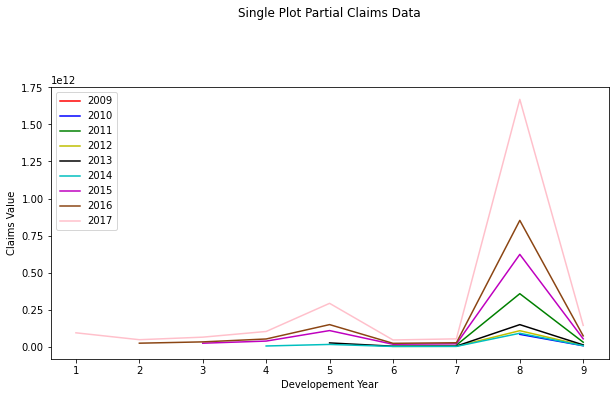

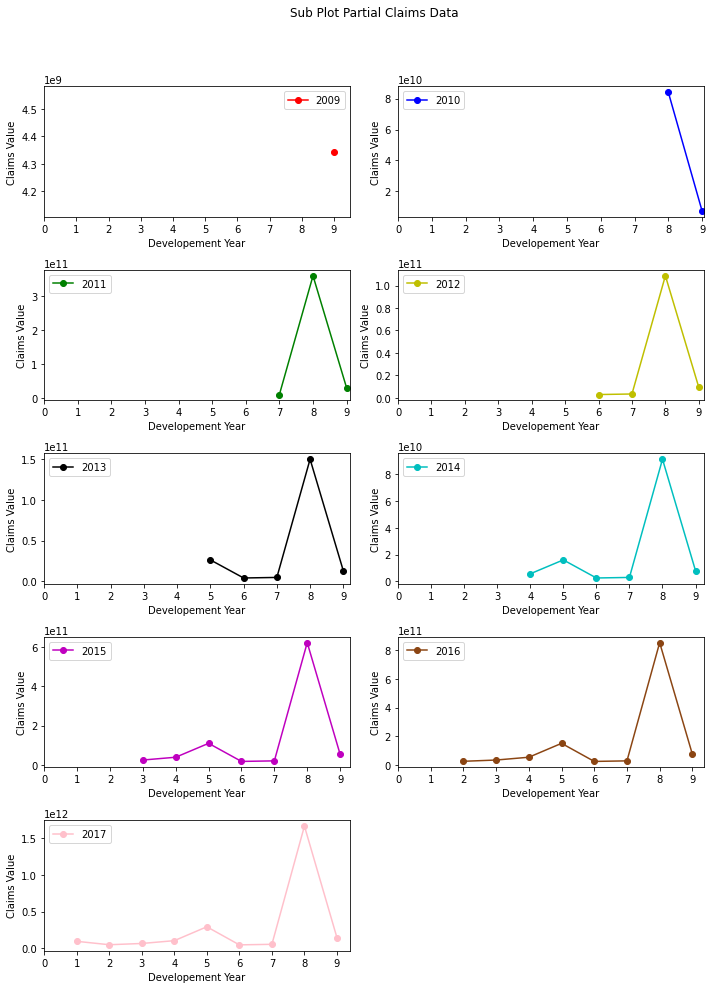

FutureUplifted_Predicted_Incremental                \
PredictedYear_Only_Lag                                    1             2   
InsuredYear                                                                 
2009                                                    NaN           NaN   
2010                                                    NaN           NaN   
2011                                                    NaN           NaN   
2012                                                    NaN           NaN   
2013                                                    NaN           NaN   
2014                                                    NaN           NaN   
2015                                                    NaN           NaN   
2016                                                    NaN  2.450874e+10   
2017                                           9.449910e+10  4.796382e+10   

                                                                  \
PredictedYear_Only_Lag             3             4             5   
InsuredYear                                                        
2009                             NaN           NaN           NaN   
2010                             NaN           NaN           NaN   
2011                             NaN           NaN           NaN   
2012                             NaN           NaN           NaN   
2013                             NaN           NaN  2.630764e+10   
2014                             NaN  5.668723e+09  1.606465e+10   
2015                    2.434968e+10  3.865676e+10  1.095498e+11   
2016                    3.330987e+10  5.288167e+10  1.498619e+11   
2017                    6.518772e+10  1.034899e+11  2.932811e+11   

                                                                                
PredictedYear_Only_Lag             6             7             8             9  
InsuredYear                                                                     
2009                             NaN           NaN           NaN  4.344151e+09  
2010                             NaN           NaN  8.401319e+10  7.276486e+09  
2011                             NaN  1.154073e+10  3.583601e+11  3.103801e+10  
2012                    3.008594e+09  3.499906e+09  1.086782e+11  9.412755e+09  
2013                    4.144766e+09  4.821618e+09  1.497197e+11  1.296741e+10  
2014                    2.530984e+09  2.944301e+09  9.142572e+10  7.918495e+09  
2015                    1.725956e+10  2.007809e+10  6.234601e+11  5.399865e+10  
2016                    2.361073e+10  2.746643e+10  8.528808e+11  7.386906e+10  
2017                    4.620641e+10  5.375204e+10  1.669095e+12  1.445624e+11

In [263]:
SinglePlotPartialClaims(DataFrameName=Predicted_df, InsuredYearColumn='InsuredYear', LagYearColumn='PredictedYear_Only_Lag', ValueColumn='FutureUplifted_Predicted_Incremental')
SubPlotPartialClaims(DataFrameName=Predicted_df, InsuredYearColumn='InsuredYear', LagYearColumn='PredictedYear_Only_Lag', ValueColumn='FutureUplifted_Predicted_Incremental')
display(PredictedTriangle)

/var/folders/4y/r8t245md0712rsd6jcyf8qn40000gn/T/ipykernel_33754/3968279318.py:22: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(2, figsize=(10,5))


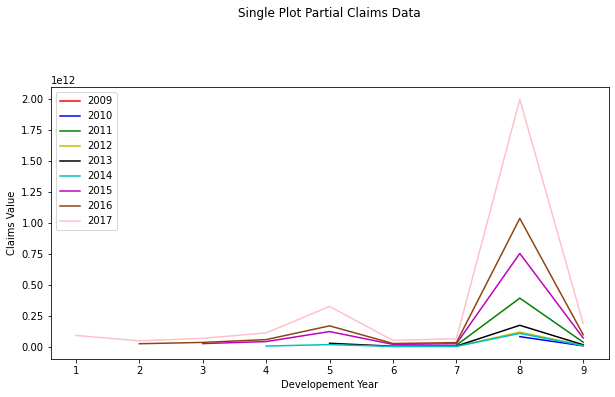

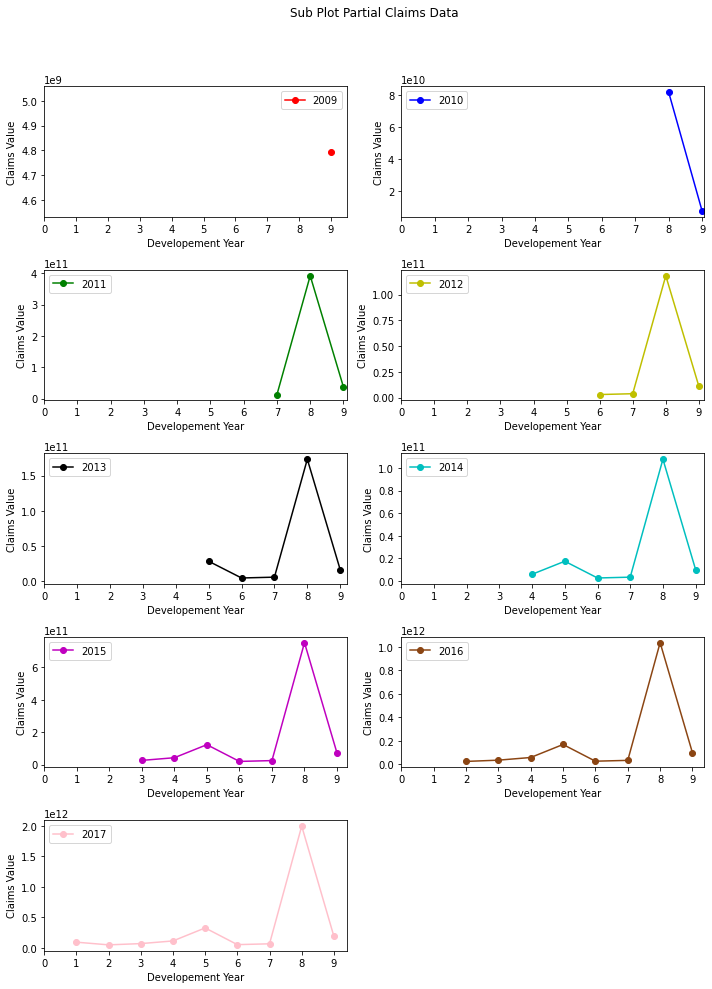

FutureUplifted_Predicted_Inflated_Incremental  \
PredictedYear_Only_Lag                                             1   
InsuredYear                                                            
2009                                                             NaN   
2010                                                             NaN   
2011                                                             NaN   
2012                                                             NaN   
2013                                                             NaN   
2014                                                             NaN   
2015                                                             NaN   
2016                                                             NaN   
2017                                                    9.163394e+10   

                                                                  \
PredictedYear_Only_Lag             2             3             4   
InsuredYear                                                        
2009                             NaN           NaN           NaN   
2010                             NaN           NaN           NaN   
2011                             NaN           NaN           NaN   
2012                             NaN           NaN           NaN   
2013                             NaN           NaN           NaN   
2014                             NaN           NaN  6.031422e+09   
2015                             NaN  2.569855e+10  4.216128e+10   
2016                    2.464332e+10  3.533324e+10  5.796804e+10   
2017                    4.749935e+10  6.810390e+10  1.117319e+11   

                                                                  \
PredictedYear_Only_Lag             5             6             7   
InsuredYear                                                        
2009                             NaN           NaN           NaN   
2010                             NaN           NaN           NaN   
2011                             NaN           NaN  1.273298e+10   
2012                             NaN  3.038800e+09  3.838685e+09   
2013                    2.823957e+10  4.453033e+09  5.625179e+09   
2014                    1.754804e+10  2.767110e+09  3.495480e+09   
2015                    1.226655e+11  1.934285e+10  2.443436e+10   
2016                    1.686543e+11  2.659472e+10  3.359508e+10   
2017                    3.250768e+11  5.126062e+10  6.475365e+10   

                                                    
PredictedYear_Only_Lag             8             9  
InsuredYear                                         
2009                             NaN  4.794624e+09  
2010                    8.186097e+10  7.678372e+09  
2011                    3.920740e+11  3.677564e+10  
2012                    1.182009e+11  1.108697e+10  
2013                    1.732106e+11  1.624676e+10  
2014                    1.076329e+11  1.009572e+10  
2015                    7.523831e+11  7.057181e+10  
2016                    1.034460e+12  9.703001e+10  
2017                    1.993895e+12  1.870228e+11

In [265]:
SinglePlotPartialClaims(DataFrameName=Predicted_df, InsuredYearColumn='InsuredYear', LagYearColumn='PredictedYear_Only_Lag', ValueColumn='FutureUplifted_Predicted_Inflated_Incremental')
SubPlotPartialClaims(DataFrameName=Predicted_df, InsuredYearColumn='InsuredYear', LagYearColumn='PredictedYear_Only_Lag', ValueColumn='FutureUplifted_Predicted_Inflated_Incremental')
display(PredictedInflatedTriangle)

In [266]:
# Cumulative
# Non-Inflated
PredictedCumTriangle = pd.pivot_table(Predicted_df, index=["InsuredYear"], columns=["PredictedYear_Only_Lag"], values=["Predicted_cumsum"])
# Inflated
PredictedInflatedCumTriangle = pd.pivot_table(Predicted_df, index=["InsuredYear"], columns=["PredictedYear_Only_Lag"], values=["Predicted_Inflated_cumsum"])

/var/folders/4y/r8t245md0712rsd6jcyf8qn40000gn/T/ipykernel_33754/3968279318.py:22: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(2, figsize=(10,5))


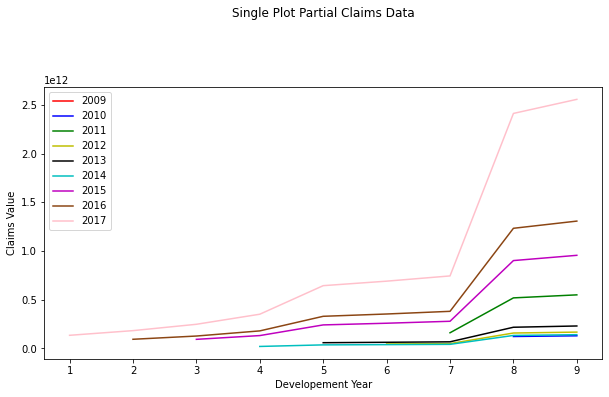

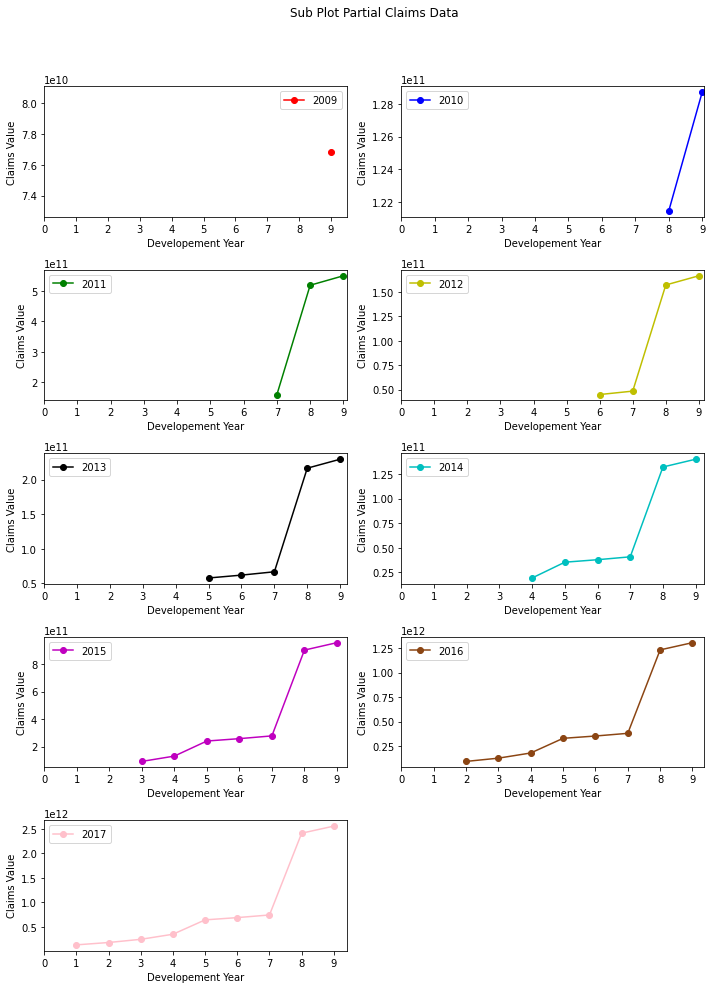

Predicted_cumsum                              \
PredictedYear_Only_Lag                1             2             3   
InsuredYear                                                           
2009                                NaN           NaN           NaN   
2010                                NaN           NaN           NaN   
2011                                NaN           NaN           NaN   
2012                                NaN           NaN           NaN   
2013                                NaN           NaN           NaN   
2014                                NaN           NaN           NaN   
2015                                NaN           NaN  9.217354e+10   
2016                                NaN  9.278166e+10  1.260915e+11   
2017                       1.336107e+11  1.815745e+11  2.467623e+11   

                                                                  \
PredictedYear_Only_Lag             4             5             6   
InsuredYear                                                        
2009                             NaN           NaN           NaN   
2010                             NaN           NaN           NaN   
2011                             NaN           NaN           NaN   
2012                             NaN           NaN  4.491036e+10   
2013                             NaN  5.772565e+10  6.187042e+10   
2014                    1.918528e+10  3.524993e+10  3.778091e+10   
2015                    1.308303e+11  2.403801e+11  2.576397e+11   
2016                    1.789732e+11  3.288351e+11  3.524459e+11   
2017                    3.502522e+11  6.435332e+11  6.897397e+11   

                                                                  
PredictedYear_Only_Lag             7             8             9  
InsuredYear                                                       
2009                             NaN           NaN  7.684323e+10  
2010                             NaN  1.214365e+11  1.287130e+11  
2011                    1.596300e+11  5.179901e+11  5.490281e+11  
2012                    4.841027e+10  1.570885e+11  1.665012e+11  
2013                    6.669204e+10  2.164118e+11  2.293792e+11  
2014                    4.072522e+10  1.321509e+11  1.400694e+11  
2015                    2.777178e+11  9.011778e+11  9.551765e+11  
2016                    3.799123e+11  1.232793e+12  1.306662e+12  
2017                    7.434917e+11  2.412587e+12  2.557149e+12

In [267]:
SinglePlotPartialClaims(DataFrameName=Predicted_df, InsuredYearColumn='InsuredYear', LagYearColumn='PredictedYear_Only_Lag', ValueColumn='Predicted_cumsum')
SubPlotPartialClaims(DataFrameName=Predicted_df, InsuredYearColumn='InsuredYear', LagYearColumn='PredictedYear_Only_Lag', ValueColumn='Predicted_cumsum')
display(PredictedCumTriangle)

/var/folders/4y/r8t245md0712rsd6jcyf8qn40000gn/T/ipykernel_33754/3968279318.py:22: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(2, figsize=(10,5))


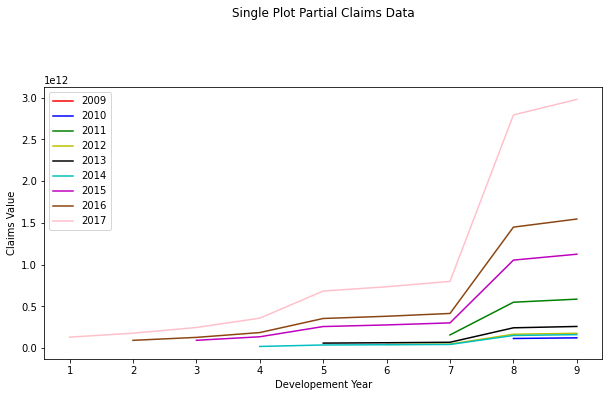

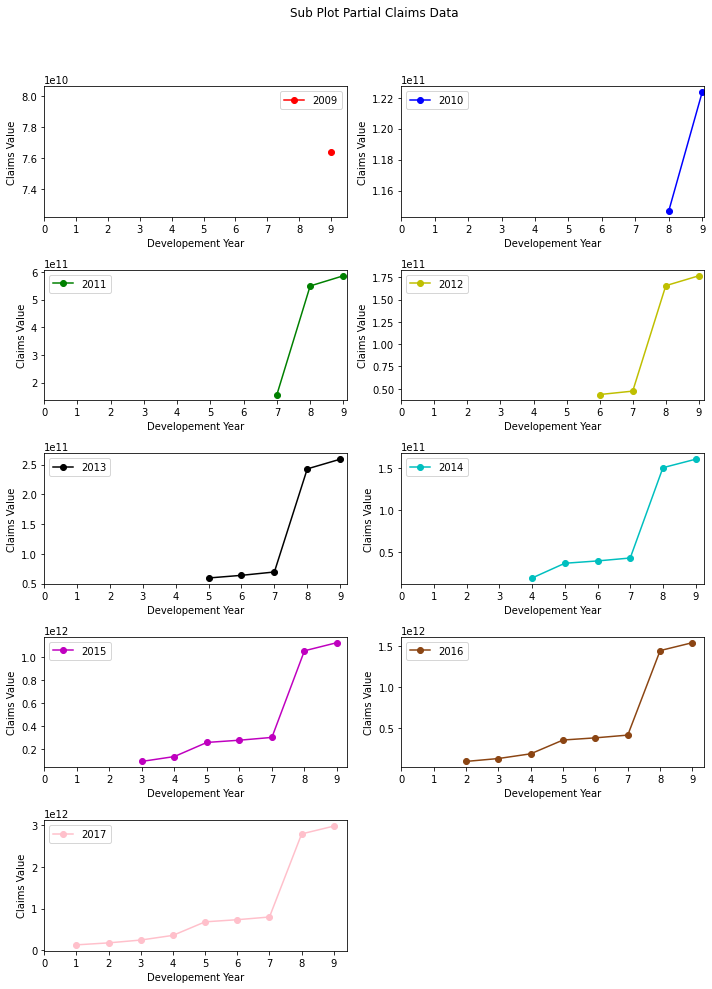

Predicted_Inflated_cumsum                              \
PredictedYear_Only_Lag                         1             2             3   
InsuredYear                                                                    
2009                                         NaN           NaN           NaN   
2010                                         NaN           NaN           NaN   
2011                                         NaN           NaN           NaN   
2012                                         NaN           NaN           NaN   
2013                                         NaN           NaN           NaN   
2014                                         NaN           NaN           NaN   
2015                                         NaN           NaN  9.295808e+10   
2016                                         NaN  9.247592e+10  1.278092e+11   
2017                                1.307456e+11  1.782449e+11  2.463488e+11   

                                                                  \
PredictedYear_Only_Lag             4             5             6   
InsuredYear                                                        
2009                             NaN           NaN           NaN   
2010                             NaN           NaN           NaN   
2011                             NaN           NaN           NaN   
2012                             NaN           NaN  4.353731e+10   
2013                             NaN  5.934620e+10  6.379923e+10   
2014                    1.932963e+10  3.687766e+10  3.964477e+10   
2015                    1.351194e+11  2.577849e+11  2.771278e+11   
2016                    1.857772e+11  3.544315e+11  3.810262e+11   
2017                    3.580807e+11  6.831575e+11  7.344181e+11   

                                                                  
PredictedYear_Only_Lag             7             8             9  
InsuredYear                                                       
2009                             NaN           NaN  7.639930e+10  
2010                             NaN  1.146716e+11  1.223500e+11  
2011                    1.571469e+11  5.492209e+11  5.859965e+11  
2012                    4.737600e+10  1.655768e+11  1.766638e+11  
2013                    6.942441e+10  2.426350e+11  2.588818e+11  
2014                    4.314025e+10  1.507731e+11  1.608688e+11  
2015                    3.015621e+11  1.053945e+12  1.124517e+12  
2016                    4.146213e+11  1.449082e+12  1.546112e+12  
2017                    7.991717e+11  2.793067e+12  2.980090e+12

In [268]:
SinglePlotPartialClaims(DataFrameName=Predicted_df, InsuredYearColumn='InsuredYear', LagYearColumn='PredictedYear_Only_Lag', ValueColumn='Predicted_Inflated_cumsum')
SubPlotPartialClaims(DataFrameName=Predicted_df, InsuredYearColumn='InsuredYear', LagYearColumn='PredictedYear_Only_Lag', ValueColumn='Predicted_Inflated_cumsum')
display(PredictedInflatedCumTriangle)

In [269]:
def SinglePlotFullClaims(PastDataFrameName, PastInsuredYearColumn, PastLagYearColumn, PastValueColumn, 
                   FutureDataFrameName, FutureInsuredYearColumn, FutureLagYearColumn, FutureValueColumn):
    """Create New df"""
    Filtered_NewColumnNames = ["Insured_Year","Year_Only_Lag","ClaimAmt"]
    # Past
    Past_Filtered_df = pd.DataFrame(PastDataFrameName[[PastInsuredYearColumn, PastLagYearColumn, PastValueColumn]])
    Past_Filtered_df.columns = Filtered_NewColumnNames
    # Future
    Future_Filtered_df = pd.DataFrame(FutureDataFrameName[[FutureInsuredYearColumn, FutureLagYearColumn, FutureValueColumn]])
    Future_Filtered_df.columns = Filtered_NewColumnNames    
    """Unique Insured Years List"""
    # Past
    Past_InsuredYr_List = list(PastDataFrameName[PastInsuredYearColumn].unique())
    # Future
    Future_InsuredYr_List = list(FutureDataFrameName[FutureInsuredYearColumn].unique())
    """Unique Lag Years List"""
    # Past
    Past_LagYr_List = list(PastDataFrameName[PastLagYearColumn].unique())
    # Future
    Future_LagYr_List = list(FutureDataFrameName[FutureLagYearColumn].unique())
    """Color List"""
    ALL_Colors = ['r','b','g','y','k', 'c', 'm', 'saddlebrown', 'pink', 'lawngreen']         
    Past_Color_List = ALL_Colors[:len(Past_InsuredYr_List)]
    Future_Color_List = ALL_Colors[:len(Future_InsuredYr_List)]
    """Plotting"""
    fig = plt.figure(2, figsize=(8,12))
    plt.title('Single Plot Full Claims Data')
    """Full Loop Plot"""
    Full_Filtered_df = pd.concat([Past_Filtered_df, Future_Filtered_df])
    for row_A in range(0,len(Past_InsuredYr_List)):
        Year_i = Past_InsuredYr_List[row_A]
        Full_SubFiltered_df = Full_Filtered_df.loc[Full_Filtered_df['Insured_Year'].isin([Year_i])]
        plt.plot(Full_SubFiltered_df['Year_Only_Lag'], Full_SubFiltered_df['ClaimAmt'], 
                 label=('Predicted %d' % Year_i), linestyle='--', color=Past_Color_List[row_A])
        plt.legend()
        plt.xlabel('Developement Year')
        plt.ylabel('Claims Value')    
    """Past Loop Plot"""
    for row_A in range(0,len(Past_InsuredYr_List)):
        Year_i = Past_InsuredYr_List[row_A]
        Past_SubFiltered_df = Past_Filtered_df.loc[Past_Filtered_df['Insured_Year'].isin([Year_i])]
        plt.plot(Past_SubFiltered_df['Year_Only_Lag'], Past_SubFiltered_df['ClaimAmt'], 
                 label=('Historical %d' % Year_i), linestyle='-', color=Past_Color_List[row_A], marker='o')
        plt.legend()
    #"""Future Loop Plot"""
    #for row_B in range(0,len(Future_InsuredYr_List)):
    #    Year_i = Future_InsuredYr_List[row_B]
    #    Future_SubFiltered_df = Future_Filtered_df.loc[Future_Filtered_df['Insured_Year'].isin([Year_i])]
    #    plt.plot(Future_SubFiltered_df['Year_Only_Lag'], Future_SubFiltered_df['ClaimAmt'], 
    #             label=str(Year_i), linestyle='--', color=Future_Color_List[row_B])    
    
    """Plot Attributes"""    
    plt.show()

In [270]:
def SubPlotFullClaims(PastDataFrameName, PastInsuredYearColumn, PastLagYearColumn, PastValueColumn, 
                   FutureDataFrameName, FutureInsuredYearColumn, FutureLagYearColumn, FutureValueColumn):
    import matplotlib.pyplot as plt
    from matplotlib import rcParams
    # https://stackoverflow.com/questions/16419670/increase-distance-between-title-and-plot-in-matplolib
    """Create New df"""
    Filtered_NewColumnNames = ["Insured_Year","Year_Only_Lag","ClaimAmt"]
    # Past
    Past_Filtered_df = pd.DataFrame(PastDataFrameName[[PastInsuredYearColumn, PastLagYearColumn, PastValueColumn]])
    Past_Filtered_df.columns = Filtered_NewColumnNames
    # Future
    Future_Filtered_df = pd.DataFrame(FutureDataFrameName[[FutureInsuredYearColumn, FutureLagYearColumn, FutureValueColumn]])
    Future_Filtered_df.columns = Filtered_NewColumnNames    
    """Unique Insured Years List"""
    # Past
    Past_InsuredYr_List = list(PastDataFrameName[PastInsuredYearColumn].unique())
    # Future
    Future_InsuredYr_List = list(FutureDataFrameName[FutureInsuredYearColumn].unique())
    """Unique Lag Years List"""
    # Past
    Past_LagYr_List = list(PastDataFrameName[PastLagYearColumn].unique())
    # Future
    Future_LagYr_List = list(FutureDataFrameName[FutureLagYearColumn].unique())
    """Color List"""
    ALL_Colors = ['r','b','g','y','k', 'c', 'm', 'saddlebrown', 'pink', 'lawngreen']         
    Past_Color_List = ALL_Colors[:len(Past_InsuredYr_List)]
    Future_Color_List = ALL_Colors[:len(Future_InsuredYr_List)]
    """Plotting"""
    fig = plt.figure(2, figsize=(12,16))
    plt.xticks([]) # remove initial blank plot default ticks
    plt.yticks([]) # remove initial blank plot default ticks
    plt.title('Sub Plot Full Claims Data')
    rcParams['axes.titlepad'] = 50 # position title
    plt.box(on=None) # Remove boundary line
    """Full Loop Plot"""
    Full_Filtered_df = pd.concat([Past_Filtered_df, Future_Filtered_df])
    i=0
    for row_A in range(0,len(Past_InsuredYr_List)):
        ax = fig.add_subplot(5, 2, 1+i)
        Year_i = Past_InsuredYr_List[row_A]
        Full_SubFiltered_df = Full_Filtered_df.loc[Full_Filtered_df['Insured_Year'].isin([Year_i])]
        plt.plot(Full_SubFiltered_df['Year_Only_Lag'], Full_SubFiltered_df['ClaimAmt'], 
                 label=('Predicted %d' % Year_i), linestyle='--', color=Past_Color_List[row_A])
        plt.legend()
        i += 1
        plt.xticks(np.arange(0, (YearEndCap-YearStartCap), step=1))
        plt.xlabel('Developement Year')
        plt.ylabel('Claims Value') 
    """Past Loop Plot"""
    i=0
    for row_A in range(0,len(Past_InsuredYr_List)):
        ax = fig.add_subplot(5, 2, 1+i)
        Year_i = Past_InsuredYr_List[row_A]
        Past_SubFiltered_df = Past_Filtered_df.loc[Past_Filtered_df['Insured_Year'].isin([Year_i])]
        plt.plot(Past_SubFiltered_df['Year_Only_Lag'], Past_SubFiltered_df['ClaimAmt'], 
                 label=('Historical %d' % Year_i), linestyle='-', color=Past_Color_List[row_A], marker='o')
        plt.legend()
        i += 1
    #"""Future Loop Plot"""
    #for row_B in range(0,len(Future_InsuredYr_List)):
    #    Year_i = Future_InsuredYr_List[row_B]
    #    Future_SubFiltered_df = Future_Filtered_df.loc[Future_Filtered_df['Insured_Year'].isin([Year_i])]
    #    plt.plot(Future_SubFiltered_df['Year_Only_Lag'], Future_SubFiltered_df['ClaimAmt'], 
    #             label=str(Year_i), linestyle='--', color=Future_Color_List[row_B])    
    """Plot Attributes"""    
    fig.tight_layout()
    plt.show()

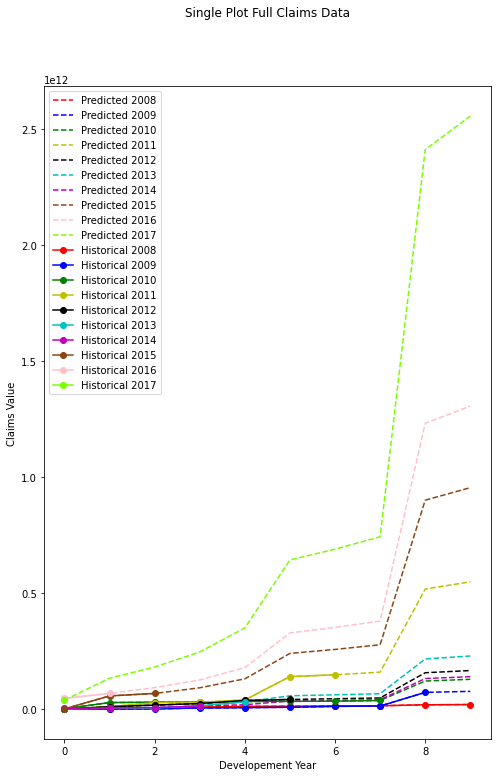

In [271]:
SinglePlotFullClaims(PastDataFrameName=py_data, PastInsuredYearColumn="Insured_Year", PastLagYearColumn="Year_Only_Lag", PastValueColumn="cumsum", 
               FutureDataFrameName=Predicted_df, FutureInsuredYearColumn="InsuredYear", FutureLagYearColumn="PredictedYear_Only_Lag", FutureValueColumn="Predicted_cumsum")

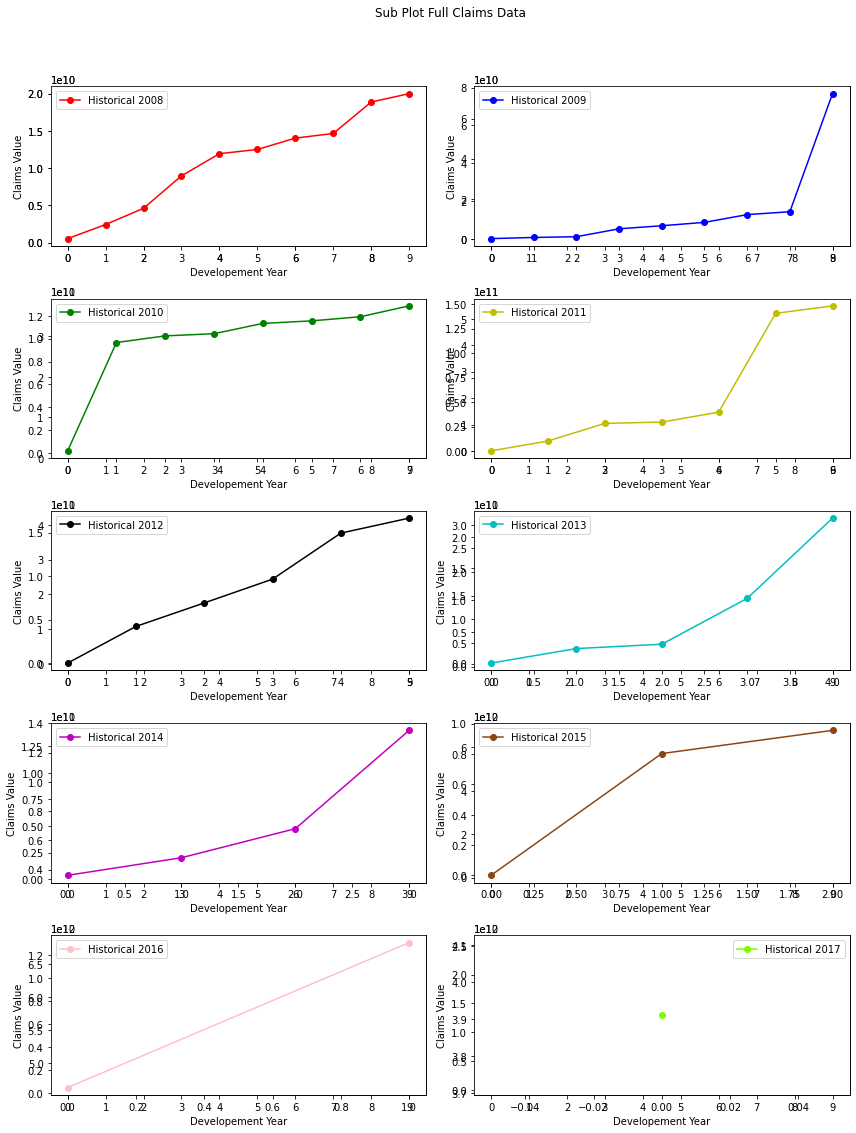

In [272]:
SubPlotFullClaims(PastDataFrameName=py_data, PastInsuredYearColumn="Insured_Year", PastLagYearColumn="Year_Only_Lag", PastValueColumn="cumsum", 
               FutureDataFrameName=Predicted_df, FutureInsuredYearColumn="InsuredYear", FutureLagYearColumn="PredictedYear_Only_Lag", FutureValueColumn="Predicted_cumsum")

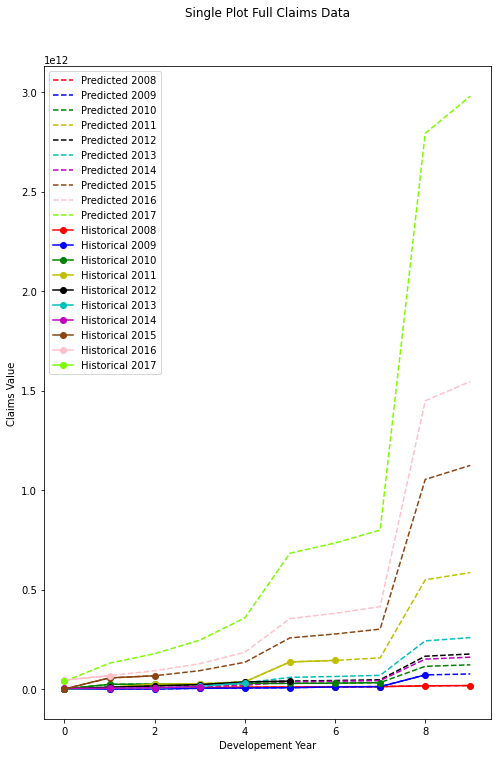

In [273]:
SinglePlotFullClaims(PastDataFrameName=py_data, PastInsuredYearColumn="Insured_Year", PastLagYearColumn="Year_Only_Lag", PastValueColumn="Inflated_cumsum", 
               FutureDataFrameName=Predicted_df, FutureInsuredYearColumn="InsuredYear", FutureLagYearColumn="PredictedYear_Only_Lag", FutureValueColumn="Predicted_Inflated_cumsum")

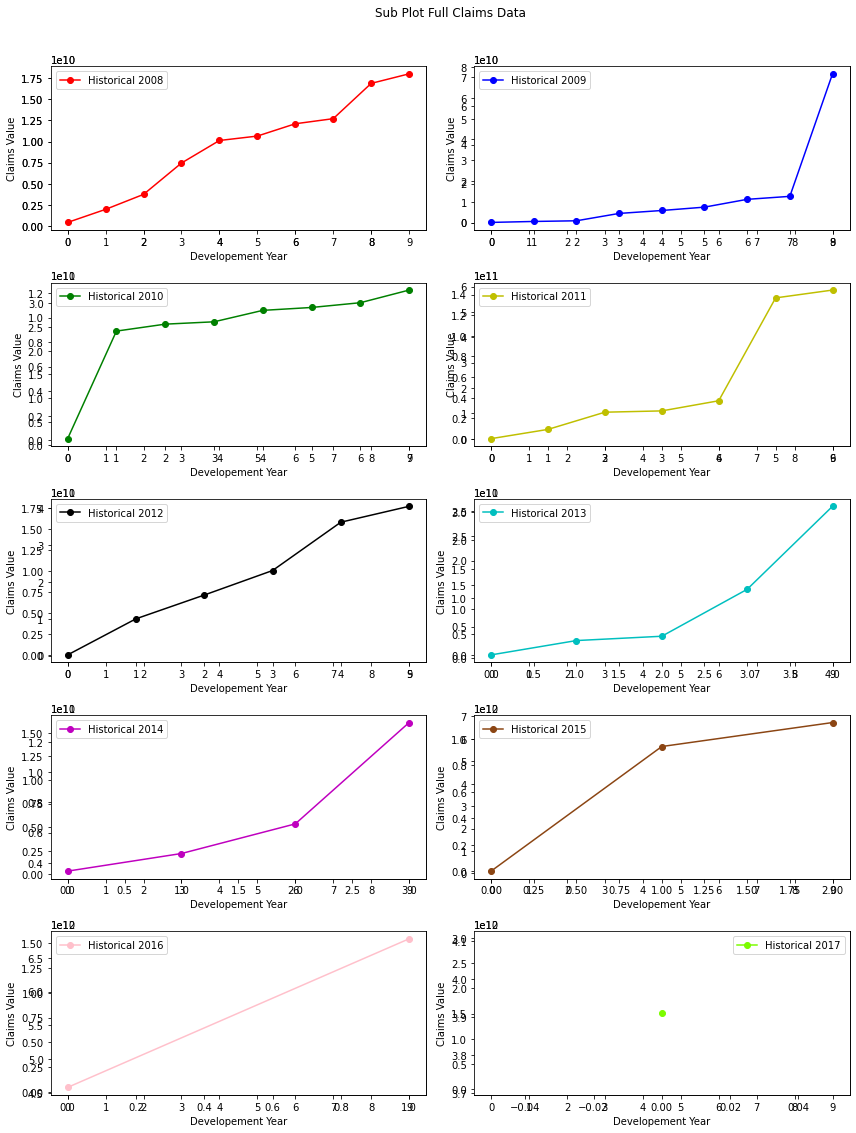

In [274]:
SubPlotFullClaims(PastDataFrameName=py_data, PastInsuredYearColumn="Insured_Year", PastLagYearColumn="Year_Only_Lag", PastValueColumn="Inflated_cumsum", 
               FutureDataFrameName=Predicted_df, FutureInsuredYearColumn="InsuredYear", FutureLagYearColumn="PredictedYear_Only_Lag", FutureValueColumn="Predicted_Inflated_cumsum")

In [275]:
InflatedReserves = Predicted_df['FutureUplifted_Predicted_Inflated_Incremental'].sum()
print(InflatedReserves)

6523942349655.525


In [276]:
NonInflatedReserves = Predicted_df['FutureUplifted_Predicted_Incremental'].sum()
print(NonInflatedReserves)

5589465745073.633


In [277]:
PercDiff = 100*(InflatedReserves/NonInflatedReserves-1)
print('Percentage Difference {}'.format(PercDiff))

Percentage Difference 16.71853173812736
